<a href="https://colab.research.google.com/github/a-partha/NYC-Subway-Analysis/blob/main/MTA_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Trend Analysis of Transit Crime Complaints with Daily Subway Ridership (Jan '24 - June '24) using NYC Open Data**

# Complaint data analysis:

**Matching complaint locations from NYPD reports to official MTA station locations:**

In [ ]:
!pip install rapidfuzz
import pandas as pd
import numpy as np
from sklearn.neighbors import BallTree
from rapidfuzz import fuzz, process
import os

# Defining path to Google Drive mount point
google_drive_path = '/content/drive/MyDrive/'

arrest_data = pd.read_csv(os.path.join(google_drive_path, 'Arrest_Data.csv'))
complaint_data = pd.read_csv(os.path.join(google_drive_path, 'Complaint_Data.csv'))
locations_data = pd.read_csv(os.path.join(google_drive_path, 'Location_Data.csv'))

# Extracting latitudes and longitudes, and converting them to radians
complaint_coords = np.radians(complaint_data[['Latitude', 'Longitude']].values)
station_coords = np.radians(locations_data[['GTFS Latitude', 'GTFS Longitude']].values)

# BallTree for fast nearest-neighbor search
station_tree = BallTree(station_coords, metric='haversine')

# Searching
distances, indices = station_tree.query(complaint_coords, k=1)

# Converting distances from radians to meters as Haversine formula gives radians
earth_radius = 6371000  # Earth's radius in meters
distances_in_meters = distances * earth_radius

# Adding nearest station and distance information to crime data
complaint_data['Matched Station Name'] = locations_data.iloc[indices.flatten()]['Stop Name'].values
complaint_data['Matched Station Latitude'] = locations_data.iloc[indices.flatten()]['GTFS Latitude'].values
complaint_data['Matched Station Longitude'] = locations_data.iloc[indices.flatten()]['GTFS Longitude'].values
complaint_data['Distance to Station (meters)'] = distances_in_meters.flatten()

In [ ]:
# Fuzzy Matching for Cases Without High Similarity

# Function for fuzzy matching
def fuzzy_match_stations(complaint_name, location_names, threshold=90):
    match = process.extractOne(complaint_name, location_names, scorer=fuzz.token_sort_ratio)
    if match and match[1] >= threshold:
        return match[0], match[1]  # Returns matched name and score
    return None, 0  # No match

# Getting all station names from the locations dataset
location_names = locations_data['Stop Name'].tolist()

# Applying fuzzy matching to complaints where similarity scores are needed
complaint_data['Fuzzy Matched Station Name'], complaint_data['Fuzzy Similarity Score (%)'] = zip(
    *complaint_data['STATION_NAME'].apply(lambda x: fuzzy_match_stations(x, location_names))
)

# Updating matched coordinates and distances for successfully fuzzy-matched rows
fuzzy_matched_indices = complaint_data['Fuzzy Matched Station Name'].notna()  # Rows with a valid fuzzy match
for idx in complaint_data[fuzzy_matched_indices].index:
    fuzzy_matched_name = complaint_data.loc[idx, 'Fuzzy Matched Station Name']
    matched_row = locations_data[locations_data['Stop Name'] == fuzzy_matched_name].iloc[0]

    # Assigning fuzzy matched coordinates
    complaint_data.loc[idx, 'Matched Station Name'] = fuzzy_matched_name
    complaint_data.loc[idx, 'Matched Station Latitude'] = matched_row['GTFS Latitude']
    complaint_data.loc[idx, 'Matched Station Longitude'] = matched_row['GTFS Longitude']

    # Calculating distance to fuzzy matched station
    complaint_data.loc[idx, 'Distance to Station (meters)'] = np.linalg.norm(
        np.radians([
            complaint_data.loc[idx, 'Latitude'] - matched_row['GTFS Latitude'],
            complaint_data.loc[idx, 'Longitude'] - matched_row['GTFS Longitude']
        ])
    ) * earth_radius

# Identifying unmatched cases
unmatched_cases = complaint_data[
    (complaint_data['Fuzzy Similarity Score (%)'] < 90) &
    complaint_data['Matched Station Name'].isna()
]

print("Unmatched Cases for Manual Review:")
print(unmatched_cases[['STATION_NAME', 'Latitude', 'Longitude']])



In [ ]:
from rapidfuzz import fuzz, process
import re

def normalize_name(name):
    """Normalize a station name for accurate similarity comparison."""
    if not name:
        return ""

    name = name.lower()
    # Replacing word equivalences
    equivalences = {
        r"\broad\b": "rd",
        r"\bavenue\b": "av",
        r"\bstreet\b": "st",
        r"\bave\b": "av",
        r"\bave\.\b": "av",
        r"\bavenues\b": "avs",
        r"\bterm\b": "terminal",
        r"\bboulevard\b": "blvd",
        r"\bpk\b": "park",
        r"\blvd\.\b": "blvd",
        r"\bpk\.\b": "park",
        r"\bst\.\b": "st",
        r"\bhisto\b": "history",
        r"\bcolle\b": "college",
        r"\bheights\b": "hts",
        r"\bdrive\b": "dr",
        r"\bturnpike\b": "tpke",
        r"\bwest\b": "w",
        r"\blane\b": "ln",
        r"\beast\b": "e",
        r"\bhighway\b": "hwy",
        r"\bparkway\b": "pwy",
        r"\bplace\b": "pl",
        r"\bstreets\b": "sts",
        r"\bsquare\b": "sq",

    }
    for pattern, replacement in equivalences.items():
        name = re.sub(pattern, replacement, name)

    name = re.sub(r"[^\w\s]", " ", name)

    tokens = sorted(name.split())
    return " ".join(tokens)

# Adding a similarity score
complaint_data['Name Similarity Score (%)'] = complaint_data.apply(
    lambda row: fuzz.ratio(normalize_name(row['STATION_NAME']),
                           normalize_name(row['Matched Station Name'])),
    axis=1
)

matched_cases = complaint_data[complaint_data['Matched Station Name'].notna()]

In [ ]:
#Filtering rows where name similarity score is less than 100%
less_than_100_similarity = complaint_data[complaint_data['Name Similarity Score (%)'] < 100]

# Keeping only unique pairs
unique_mismatches = less_than_100_similarity.drop_duplicates(subset=['STATION_NAME', 'Matched Station Name'])

print("Unique Rows with Name Similarity Score:")
unique_mismatches[['STATION_NAME', 'Matched Station Name','Name Similarity Score (%)', 'Distance to Station (meters)', 'Latitude', 'Longitude','Matched Station Latitude', 'Matched Station Longitude']]

Unique Rows with Name Similarity Score:


,STATION_NAME,Matched Station Name,Name Similarity Score (%),Distance to Station (meters),Latitude,Longitude,Matched Station Latitude,Matched Station Longitude
18,CHAMBERS ST.-WORLD TRADE CENTE,Cortlandt St,29.268293,107.505702,40.711535,-74.010464,40.710668,-74.011029
30,W. 4 STREET,Christopher St-Stonewall,33.333333,216.329032,40.733897,-74.005396,40.733422,-74.002906
34,45 STREET,53 St,80.000000,39.520464,40.644790,-74.014324,40.645069,-74.014034
36,CHAMBERS STREET,Brooklyn Bridge-City Hall,27.777778,9.957046,40.713135,-74.004058,40.713065,-74.004131
38,PARK PLACE,City Hall,25.000000,101.588368,40.712531,-74.007665,40.713282,-74.006978
...,...,...,...,...,...,...,...,...
2289,SUTPHIN BLVD.-ARCHER AVE.,Sutphin Blvd-Archer Av-JFK Airport,78.571429,21.943487,40.700582,-73.807742,40.700486,-73.807969
2322,169 STREET,Kew Gardens-Union Tpke,14.285714,2430.185694,40.730113,-73.810909,40.714441,-73.831008
2358,PARSONS/ARCHER-JAMAICA CENTER,169 St,11.428571,366.712661,40.707240,-73.792727,40.710470,-73.793604
2370,DISTRICT 23 OFFICE,Beach 36 St,27.586207,122.861404,40.596329,-73.767392,40.595398,-73.768175


In [ ]:
manual_mappings = {
    "W. 4 STREET": "W 4 St-Wash Sq",
    "45 STREET": "45 St",
    "CHAMBERS STREET": "Brooklyn Bridge-City Hall",
    "PARK PLACE": "Park Place",
    "BROADWAY/NASSAU": "Fulton St",
    "CHRISTOPHER ST.-SHERIDAN SQ.": "Christopher St-Stonewall",
    "WEST 34 STREET/HUDSON YARDS": "34 St-Hudson Yards",
    "42 ST.-TIMES SQUARE": "Times Sq-42 St",
    "NEW UTRECHT AVENUE": "62 St",
    "BROADWAY/LAFAYETTE": "Broadway-Lafayette St",
    "42 ST.-PORT AUTHORITY BUS TERM": "42 St-Port Authority Bus Terminal",
    "42 ST.-GRAND CENTRAL": "Grand Central-42 St",
    "34 STREET": "34 St-Penn Station",
    "BROOKLYN BRIDGE-CITY HALL": "Brooklyn Bridge-City Hall",
    "BAY PARKWAY": "Bay Pkwy",
    "SPRING STREET": "Spring St",
    "14 STREET": "14 St-Union Sq",
    "UNION SQUARE": "14 St-Union Sq",
    "DISTRICT 4 OFFICE": "14 St-Union Sq",
    "59 ST.-COLUMBUS CIRCLE": "42 St-Port Authority Bus Terminal",
    "LAWRENCE STREET": "Jay St-MetroTech",
    "ESSEX STREET": "Delancey St-Essex St",
    "JAY STREET-BOROUGH HALL": "Jay St-MetroTech",
    "9TH STREET": "4 Av-9 St",
    "DELANCEY STREET": "Delancey St-Essex St",
    "HOYT-SCHERMERHORN": "Hoyt-Schermerhorn Sts",
    "42 STREET": "42 St-Bryant Pk",
    "14 ST.-UNION SQUARE": "14 St-Union Sq",
    "HIGH STREET": "High St",
    "PACIFIC STREET": "Atlantic Av-Barclays Ctr",
    "ATLANTIC AVENUE": "Atlantic Av-Barclays Ctr",
    "57 STREET": "57 St-7 Av",
    "7 AVENUE": "7 Av",
    "7TH AVENUE": "7 Av",
    "5 AVENUE": "5 Av/53 St",
    "BRIGHTON BEACH": "Brighton Beach",
    "NEWKIRK AVENUE": "Newkirk Av-Little Haiti",
    "LEXINGTON AVE.": "Lexington Av/63 St",
    "110 ST.-CATHEDRAL PKWY.": "Cathedral Pkwy (110 St)",
    "KINGS HIGHWAY": "Kings Hwy",
    "72ND STREET": "72 St",
    "FRANKLIN AVENUE": "Franklin Av-Medgar Evers College",
    "45 ROAD-COURT HOUSE SQUARE": "Vernon Blvd-Jackson Av",
    "135 STREET": "135 St",
    "QUEENSBORO PLAZA": "Queensboro Plaza",
    "DISTRICT 32 OFFICE": "Botanic Garden",
    "BOTANIC GARDEN": "Botanic Garden",
    "PRESIDENT STREET": "President St-Medgar Evers College",
    "110 ST.-CENTRAL PARK NORTH": "Central Park North (110 St)",
    "96TH STREET": "96 St",
    "23 STREET-ELY AVENUE": "Court Sq-23 St",
    "UTICA AVE.-CROWN HEIGHTS": "Crown Hts-Utica Av",
    "168 ST.-WASHINGTON HTS.": "168 St",
    "39 AVENUE": "39 Av-Dutch Kills",
    "KOSCIUSKO STREET": "Kosciuszko St",
    "33 STREET": "33 St-Rawson St",
    "149 ST.-GRAND CONCOURSE": "149 St-Grand Concourse",
    "40 STREET": "40 St-Lowery St",
    "DISTRICT 11 OFFICE": "161 St-Yankee Stadium",
    "46 STREET": "46 St-Bliss St",
    "WYCKOFF AVENUE": "Myrtle-Wyckoff Avs",
    "BROADWAY-EASTERN PKWY": "Eastern Pkwy-Brooklyn Museum",
    "BROADWAY-EAST NEW YORK": "Broadway Junction",
    "DISTRICT 33 OFFICE": "Broadway Junction",
    "EAST TREMONT AVE.-WEST FARMS S": "West Farms Sq-E Tremont Av",
    "ROOSEVELT AVE.-JACKSON HEIGHTS": "74 St-Broadway",
    "METROPOLITAN AVENUE": "Metropolitan Av",
    "EAST 174 STREET": "174 St",
    "74 ST.-BROADWAY": "74 St-Broadway",
    "GRAND AVE.-NEWTON": "Grand Av-Newtown",
    "SOUNDVIEW AVENUE": "Morrison Av-Soundview",
    "EAST 177 ST.-PARKCHESTER": "Parkchester",
    "238 ST.-NEREID AVE.": "Nereid Av",
    "WILLETS POINT-SHEA STADIUM": "Mets-Willets Point",
    "DYRE AVE.-EASTCHESTER": "Eastchester-Dyre Av",
    "71 AVE.-FOREST HILLS": "Forest Hills-71 Av",
    "AQUEDUCT-NORTH CONDUIT AVE.": "Aqueduct-N Conduit Av",
    "EAST TREMONT AV.-WESTCHESTER S": "Westchester Sq-E Tremont Av",
    "BAYCHESTER AVENUE": "Baychester Av",
    "LEFFERTS BLVD.": "Ozone Park-Lefferts Blvd",
    "VAN WYCK BLVD.-BRIARWOOD": "Briarwood",
    "SUTPHIN BLVD.-ARCHER AVE.": "Sutphin Blvd-Archer Av-JFK Airport",
    "169 STREET": "169 St",
    "PARSONS/ARCHER-JAMAICA CENTER": "Jamaica Center-Parsons/Archer",
}

# Applying manual mappings
complaint_data['Matched Station Name'] = complaint_data.apply(
    lambda row: manual_mappings[row['STATION_NAME']] if row['STATION_NAME'] in manual_mappings else row['Matched Station Name'],
    axis=1
)

complaint_data['Name Similarity Score (%)'] = complaint_data.apply(
    lambda row: fuzz.ratio(normalize_name(row['STATION_NAME']), normalize_name(row['Matched Station Name'])),
    axis=1
)

In [ ]:
# After applying manual mappings
updated_less_than_100_similarity = complaint_data[complaint_data['Name Similarity Score (%)'] < 100]

updated_unique_mismatches = updated_less_than_100_similarity.drop_duplicates(subset=['STATION_NAME', 'Matched Station Name'])

print("Updated Unique Mismatches After Manual Mapping:")
updated_unique_mismatches[['STATION_NAME', 'Matched Station Name',
                                 'Name Similarity Score (%)', 'Distance to Station (meters)',
                                 'Latitude', 'Longitude', 'Matched Station Latitude', 'Matched Station Longitude']]

Updated Unique Mismatches After Manual Mapping:


,STATION_NAME,Matched Station Name,Name Similarity Score (%),Distance to Station (meters),Latitude,Longitude,Matched Station Latitude,Matched Station Longitude
18,CHAMBERS ST.-WORLD TRADE CENTE,Cortlandt St,29.268293,107.505702,40.711535,-74.010464,40.710668,-74.011029
30,W. 4 STREET,W 4 St-Wash Sq,60.000000,216.329032,40.733897,-74.005396,40.733422,-74.002906
36,CHAMBERS STREET,Brooklyn Bridge-City Hall,27.777778,9.957046,40.713135,-74.004058,40.713065,-74.004131
51,BROADWAY/NASSAU,Fulton St,25.000000,5.182352,40.710220,-74.007744,40.710197,-74.007691
58,CHAMBERS ST.-WORLD TRADE CENTE,City Hall,31.578947,113.186461,40.714165,-74.006309,40.713282,-74.006978
...,...,...,...,...,...,...,...,...
2253,LEFFERTS BLVD.,Ozone Park-Lefferts Blvd,70.270270,140.444694,40.686234,-73.824175,40.685951,-73.825798
2261,VAN WYCK BLVD.-BRIARWOOD,Briarwood,56.250000,121.261308,40.710189,-73.821118,40.709179,-73.820574
2289,SUTPHIN BLVD.-ARCHER AVE.,Sutphin Blvd-Archer Av-JFK Airport,78.571429,21.943487,40.700582,-73.807742,40.700486,-73.807969
2370,DISTRICT 23 OFFICE,Beach 36 St,27.586207,122.861404,40.596329,-73.767392,40.595398,-73.768175


In [ ]:
# Special mappings = More manual mappings after reviewing proximity of locations
special_mappings = {
    "59 STREET": "59 St",
    "86 STREET": "86 St",
    "135 STREET": "135 St",
    "86TH STREET": "86 St",
    "145 STREET": "145 St",
    "125 STREET": "125 St",
    "200 ST.-DYCKMAN ST.": "Dyckman St",
    "NEW LOTS AVENUE": "New Lots Av",
    "LEXINGTON AVENUE" : "Lexington Av/53 St",
    "ROOSEVELT ISLAND": "Astoria Blvd",
    "LIVONIA AVENUE":"Livonia Av",
    "DISTRICT 23 OFFICE":"Beach 36 St",
    "BEACH 36 STREET":"Far Rockaway-Mott Av"
}

# Applying special mappings
complaint_data['Matched Station Name'] = complaint_data.apply(
    lambda row: special_mappings[row['STATION_NAME']] if row['STATION_NAME'] in special_mappings else row['Matched Station Name'],
    axis=1
)

# Function to calculate distance between two latitude-longitude points
def haversine_distance(lat1, lon1, lat2, lon2):
    # Convert degrees to radians
    lat1_rad, lon1_rad = np.radians(lat1), np.radians(lon1)
    lat2_rad, lon2_rad = np.radians(lat2), np.radians(lon2)
    dlat = lat2_rad - lat1_rad
    dlon = lon2_rad - lon1_rad
    a = np.sin(dlat / 2)**2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon / 2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    radius_earth = 6371000  # in meters
    return radius_earth * c

mapped_rows = complaint_data['Matched Station Name'].isin(special_mappings.values())

# Picking closest location for each mapped row when there are multiple entries for the matched station name
for idx in complaint_data[mapped_rows].index:
    matched_station_name = complaint_data.at[idx, 'Matched Station Name']
    complaint_lat = complaint_data.at[idx, 'Latitude']
    complaint_lon = complaint_data.at[idx, 'Longitude']

    candidate_stations = locations_data[locations_data['Stop Name'] == matched_station_name]

    # If there's only one station with that name
    if len(candidate_stations) == 1:
        chosen_station = candidate_stations.iloc[0]
    else:
        candidate_stations = candidate_stations.assign(
            Distance=candidate_stations.apply(lambda row: haversine_distance(
                complaint_lat, complaint_lon,
                row['GTFS Latitude'], row['GTFS Longitude']
            ), axis=1)
        )
        # Picking the closest station
        chosen_station = candidate_stations.sort_values('Distance').iloc[0]

    # Updating the complaint_data with the chosen station details
    complaint_data.at[idx, 'Matched Station Latitude'] = chosen_station['GTFS Latitude']
    complaint_data.at[idx, 'Matched Station Longitude'] = chosen_station['GTFS Longitude']

    # Recalculating distance using chosen station
    complaint_data.at[idx, 'Distance to Station (meters)'] = haversine_distance(
        complaint_lat, complaint_lon,
        chosen_station['GTFS Latitude'], chosen_station['GTFS Longitude']
    )

# Displaying only rows that with special mappings
print("Special Mapping Results:")
special_mapping_results = complaint_data[mapped_rows][['STATION_NAME', 'Matched Station Name',
                                                       'Latitude', 'Longitude',
                                                       'Matched Station Latitude', 'Matched Station Longitude',
                                                       'Distance to Station (meters)']]
display(special_mapping_results)


Special Mapping Results:


,STATION_NAME,Matched Station Name,Latitude,Longitude,Matched Station Latitude,Matched Station Longitude,Distance to Station (meters)
0,86 STREET,86 St,40.622799,-74.028350,40.622687,-74.028398,13.061793
2,86 STREET,86 St,40.622799,-74.028350,40.622687,-74.028398,13.061793
3,59 STREET,59 St,40.641435,-74.017815,40.641362,-74.017881,9.873886
4,59 STREET,59 St,40.641435,-74.017815,40.641362,-74.017881,9.873886
7,59 STREET,59 St,40.641435,-74.017815,40.641362,-74.017881,9.873886
...,...,...,...,...,...,...,...
2370,DISTRICT 23 OFFICE,Beach 36 St,40.596329,-73.767392,40.595398,-73.768175,122.861404
2371,FAR ROCKAWAY-MOTT AVE.,Far Rockaway-Mott Av,40.604783,-73.753998,40.603995,-73.755405,147.597634
2372,FAR ROCKAWAY-MOTT AVE.,Far Rockaway-Mott Av,40.604783,-73.753998,40.603995,-73.755405,147.597634
2373,FAR ROCKAWAY-MOTT AVE.,Far Rockaway-Mott Av,40.604783,-73.753998,40.603995,-73.755405,147.597634


In [ ]:
# Displaying all types of mappings
display(complaint_data[[
    'STATION_NAME',
    'Matched Station Name',
    'Name Similarity Score (%)',
    'Distance to Station (meters)',
    'Latitude',
    'Longitude',
    'Matched Station Latitude',
    'Matched Station Longitude'
]])


,STATION_NAME,Matched Station Name,Name Similarity Score (%),Distance to Station (meters),Latitude,Longitude,Matched Station Latitude,Matched Station Longitude
0,86 STREET,86 St,100.000000,13.061793,40.622799,-74.028350,40.622687,-74.028398
1,BAY RIDGE AVENUE,Bay Ridge Av,100.000000,40.841065,40.634616,-74.023520,40.634967,-74.023377
2,86 STREET,86 St,100.000000,13.061793,40.622799,-74.028350,40.622687,-74.028398
3,59 STREET,59 St,100.000000,9.873886,40.641435,-74.017815,40.641362,-74.017881
4,59 STREET,59 St,100.000000,9.873886,40.641435,-74.017815,40.641362,-74.017881
...,...,...,...,...,...,...,...,...
2370,DISTRICT 23 OFFICE,Beach 36 St,27.586207,122.861404,40.596329,-73.767392,40.595398,-73.768175
2371,FAR ROCKAWAY-MOTT AVE.,Far Rockaway-Mott Av,100.000000,147.597634,40.604783,-73.753998,40.603995,-73.755405
2372,FAR ROCKAWAY-MOTT AVE.,Far Rockaway-Mott Av,100.000000,147.597634,40.604783,-73.753998,40.603995,-73.755405
2373,FAR ROCKAWAY-MOTT AVE.,Far Rockaway-Mott Av,100.000000,147.597634,40.604783,-73.753998,40.603995,-73.755405


In [ ]:
complaint_data = complaint_data[complaint_data['PREM_TYP_DESC'] == 'TRANSIT - NYC SUBWAY'] #To ensure selection of subway crimes only

In [ ]:
# Verifying mapping success
unmatched_cases = complaint_data[
    (complaint_data['Matched Station Name'].isna())
]

if unmatched_cases.empty:
    print("No unmatched cases found.")
else:
    print("Unmatched Cases for Review:")
    display(unmatched_cases[['STATION_NAME', 'Latitude', 'Longitude']])


No unmatched cases found.


In [ ]:
columns_to_keep = [
    'CMPLNT_NUM', 'BORO_NM', 'CMPLNT_FR_DT', 'CMPLNT_FR_TM',
    'CMPLNT_TO_DT', 'CMPLNT_TO_TM', 'CRM_ATPT_CPTD_CD',
    'KY_CD','OFNS_DESC','PD_DESC','RPT_DT',
    'SUSP_AGE_GROUP','SUSP_RACE', 'SUSP_SEX', 'VIC_AGE_GROUP','VIC_RACE', 'VIC_SEX',
    'STATION_NAME','Matched Station Name', 'Matched Station Latitude','Matched Station Longitude', 'Distance to Station (meters)',
]

filtered_complaint_data = complaint_data[columns_to_keep]


In [ ]:
filtered_complaint_data.to_csv('filtered_complaint_data.csv', index=False)

**Matching complaint locations to station locations from daily ridership data:**

In [ ]:
daily_ridership = pd.read_csv(os.path.join(google_drive_path, 'Comprehensive_Daily_Ridership.csv'))
filtered_complaint_data = pd.read_csv(os.path.join(google_drive_path, 'filtered_complaint_data.csv'))
clean_station_daily_ridership=pd.read_csv(os.path.join(google_drive_path, 'cleaned_station_daily_ridership.csv'))

In [ ]:
!pip install rapidfuzz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 24.6 MB/s eta 0:00:00


In [ ]:
# Function for cleaning station names
def clean_station_name(name):
    # Removing anything in parentheses and special characters
    name = re.sub(r'\(.*?\)', '', name)
    # Replacing hyphens, slashes, and extra whitespace
    name = re.sub(r'[-/]', ' ', name)
    name = re.sub(r'\s+', ' ', name)
    name = name.replace('&', 'and')  # Replacing '&' with 'and'
    return name.strip().lower()  # Converting to lowercase for case-insensitive matching

# Cleaning both station names
filtered_complaint_data['cleaned_station'] = filtered_complaint_data['Matched Station Name'].apply(clean_station_name)

# Extracting relevant columns from complaint data
fc_stations = filtered_complaint_data['cleaned_station'].unique()
fc_latitudes = filtered_complaint_data['Matched Station Latitude'].values
fc_longitudes = filtered_complaint_data['Matched Station Longitude'].values

# Extracting relevant columns from ridership data
ridership_station_list = daily_ridership['cleaned_station'].unique()
ridership_latitudes = daily_ridership['latitude'].values
ridership_longitudes = daily_ridership['longitude'].values

# Function to calculate distance between two latitude-longitude points
def calculate_distance(lat1, lon1, lat2, lon2):
    return geodesic((lat1, lon1), (lat2, lon2)).km

# Fuzzy matching function to check for exact matches first, then fuzzy match, and finally check the distance
def fuzzy_match_crime_to_ridership_with_location(
        crime_stations, crime_latitudes, crime_longitudes,
        ridership_stations, ridership_latitudes, ridership_longitudes,
        fuzzy_threshold=80, location_threshold=0.5):
    match_dict = {}
    low_confidence_matches = []

    # Manual station mappings
    manual_mappings = {
        'cortlandt st': 'wtc cortlandt',
        'times sq 42 st': 'times sq 42 st 42 st',
        'park place': 'park pl',
        'brooklyn bridge city hall': 'brooklyn bridge city hall chambers st',
        '6 av':'14 st 6 av',
        '74 st broadway':'74 broadway jackson hts roosevelt av',
        'jackson hts roosevelt av':'74 broadway jackson hts roosevelt av',
        '14 st':'14 st 8 av',
        'lexington av 53 st':'lexington av 53 st 51 st',
        '42 st port authority bus terminal':'times sq 42 st 42 st',
        'franklin av medgar evers college':'franklin av botanic garden',
        'bleecker st':'broadway lafayette st bleecker st',
        '51 st':'lexington av 53 st 51 st',
        '62 st':'new utrecht av 62 st',
        'borough hall':'court st borough hall',
        'broadway lafayette st': 'broadway lafayette st bleecker st',
        '42 st bryant pk': 'bryant pk 5 av',
        'metropolitan av': 'lorimer st metropolitan av',
        'court sq 23 st': 'court sq',
        'botanic garden': 'franklin av botanic garden',
        'whitehall st south ferry': 'south ferry whitehall st',
        'south ferry': 'south ferry whitehall st',
        'christopher st stonewall': 'christopher st sheridan sq',
        'court st':'court st borough hall',
    }

    # List of stations to exclude from fuzzy matching and treat as standalone stations
    standalone_stations = ['east broadway','president st medgar evers college','grasmere']

    for i, crime_station in enumerate(crime_stations):

        # First check if the crime station is a known standalone station
        if clean_station_name(crime_station) in [clean_station_name(station) for station in standalone_stations]:
            if crime_station in ridership_stations:
                match_dict[crime_station] = crime_station
                print(f"Exact match found for standalone station: '{crime_station}'")
            else:
                match_dict[crime_station] = None  # No match found
                print(f"No match found for standalone station: '{crime_station}'")
            continue  # Skipping fuzzy matching for known standalone stations


       # Checking for manual mapping
        mapped_station = manual_mappings.get(clean_station_name(crime_station))

        if mapped_station:
            if mapped_station in ridership_stations:
                match_dict[crime_station] = mapped_station
                print(f"Manual match: '{crime_station}' mapped to '{mapped_station}'")
            else:
                match_dict[crime_station] = None  # No match found
                print(f"No match found for manual mapping: '{crime_station}' to '{mapped_station}'")
            continue  # Skipping fuzzy matching if manual mapping exists


        # Checking for exact match
        if crime_station in ridership_stations:
            match_dict[crime_station] = crime_station
            print(f"Exact match found: '{crime_station}'")
            continue

        # Performing fuzzy matching for stations without exact matches
        result = process.extractOne(crime_station, ridership_stations, scorer=fuzz.token_sort_ratio)

        if result is not None:
            match, fuzzy_score = result[0], result[1]  # Extracting station name and fuzzy score

            # First, check if the fuzzy score meets the threshold
            if fuzzy_score >= fuzzy_threshold:
                # Finding index of matched station
                index = np.where(ridership_stations == match)[0][0]  # First occurrence
                # Calculate distance using it
                crime_location = (crime_latitudes[i], crime_longitudes[i])
                ridership_location = ridership_latitudes[index], ridership_longitudes[index]
                distance = calculate_distance(*crime_location, *ridership_location)

                if distance <= location_threshold:
                    match_dict[crime_station] = match
                    print(f"Matched '{crime_station}' to '{match}' with fuzzy score: {fuzzy_score} and distance: {distance} km")
                else:
                    match_dict[crime_station] = None
                    low_confidence_matches.append({
                        'crime_station': crime_station,
                        'fuzzy_match': match,
                        'fuzzy_score': fuzzy_score,
                        'location_match': None,
                        'location_distance': distance
                    })
                    print(f"Discarded match '{crime_station}' to '{match}' due to large distance: {distance} km")
            else:
                match_dict[crime_station] = None  # Fuzzy match did not meet threshold
                low_confidence_matches.append({
                    'crime_station': crime_station,
                    'fuzzy_match': match,
                    'fuzzy_score': fuzzy_score,
                    'location_match': None,
                    'location_distance': None
                })
                print(f"Low confidence match: '{crime_station}' (fuzzy score: {fuzzy_score})")
        else:
            match_dict[crime_station] = None  # No match found at all

    # Checking low confidence matches
    if low_confidence_matches:
        print("\nLow confidence matches found:")
        for match in low_confidence_matches:
            print(match)
    else:
        print("\nNo low confidence matches found.")

    return match_dict


# Fuzzy matching with location fallback
station_mapping = fuzzy_match_crime_to_ridership_with_location(
    fc_stations, fc_latitudes, fc_longitudes,
    ridership_station_list, ridership_latitudes, ridership_longitudes,
    fuzzy_threshold=80, location_threshold=0.5
)

# Mapping matched ridership data'station names to complaint data
filtered_complaint_data['mapped_ridership_station'] = filtered_complaint_data['cleaned_station'].map(station_mapping)

In [ ]:
filtered_complaint_data[['STATION_NAME', 'Matched Station Name', 'cleaned_station', 'mapped_ridership_station']]

,STATION_NAME,Matched Station Name,cleaned_station,mapped_ridership_station
0,86 STREET,86 St,86 st,86 st
1,BAY RIDGE AVENUE,Bay Ridge Av,bay ridge av,bay ridge av
2,86 STREET,86 St,86 st,86 st
3,59 STREET,59 St,59 st,59 st
4,59 STREET,59 St,59 st,59 st
...,...,...,...,...
2249,DISTRICT 23 OFFICE,Beach 36 St,beach 36 st,beach 36 st
2250,FAR ROCKAWAY-MOTT AVE.,Far Rockaway-Mott Av,far rockaway mott av,far rockaway mott av
2251,FAR ROCKAWAY-MOTT AVE.,Far Rockaway-Mott Av,far rockaway mott av,far rockaway mott av
2252,FAR ROCKAWAY-MOTT AVE.,Far Rockaway-Mott Av,far rockaway mott av,far rockaway mott av


In [ ]:
filtered_complaint_data = filtered_complaint_data.drop('cleaned_station', axis=1)
filtered_complaint_data.columns

Index(['CMPLNT_NUM', 'BORO_NM', 'CMPLNT_FR_DT', 'CMPLNT_FR_TM', 'CMPLNT_TO_DT',
       'CMPLNT_TO_TM', 'CRM_ATPT_CPTD_CD', 'KY_CD', 'OFNS_DESC', 'PD_DESC',
       'RPT_DT', 'SUSP_AGE_GROUP', 'SUSP_RACE', 'SUSP_SEX', 'VIC_AGE_GROUP',
       'VIC_RACE', 'VIC_SEX', 'STATION_NAME', 'Matched Station Name',
       'Matched Station Latitude', 'Matched Station Longitude',
       'Distance to Station (meters)', 'mapped_ridership_station'],
      dtype='object')

**Adding daily ridership as a separate column to the mapped complaint dataset for days with complaints:**

In [ ]:
clean_station_daily_ridership.head()

,cleaned_station,date,daily_ridership
0,1 av,2024-01-01,8940.0
1,1 av,2024-01-02,14399.0
2,1 av,2024-01-03,15842.0
3,1 av,2024-01-04,15900.0
4,1 av,2024-01-05,16968.0


In [ ]:
filtered_complaint_data['CMPLNT_FR_DT'] = pd.to_datetime(filtered_complaint_data['CMPLNT_FR_DT'])
filtered_complaint_data['CMPLNT_TO_DT'] = pd.to_datetime(filtered_complaint_data['CMPLNT_TO_DT'])
filtered_complaint_data['CMPLNT_FR_TM'] = pd.to_datetime(filtered_complaint_data['CMPLNT_FR_TM'], format='%H:%M:%S').dt.time
filtered_complaint_data['CMPLNT_TO_TM'] = pd.to_datetime(filtered_complaint_data['CMPLNT_TO_TM'], format='%H:%M:%S').dt.time

# Calculate total number of days for each crime
filtered_complaint_data['crime_duration'] = (filtered_complaint_data['CMPLNT_TO_DT'] - filtered_complaint_data['CMPLNT_FR_DT']).dt.days + 1

# Identifying the complaint day with most crime activity
def get_peak_crime_day(row):
    if row['crime_duration'] == 1:  # Single-day crime
        return row['CMPLNT_FR_DT']
    else:
        # Identifying peak crime day based on time weights
        start_day_fraction = (
            1 - (pd.Timestamp.combine(row['CMPLNT_FR_DT'], row['CMPLNT_FR_TM']) - pd.Timestamp(row['CMPLNT_FR_DT'])).total_seconds() / 86400
        )
        end_day_fraction = (
            (pd.Timestamp.combine(row['CMPLNT_TO_DT'], row['CMPLNT_TO_TM']) - pd.Timestamp(row['CMPLNT_TO_DT'])).total_seconds() / 86400
        )
        middle_days = row['crime_duration'] - 2  # number of days with full impact between start and end

        # Calculating fractions for each day
        fractions = [start_day_fraction] + [1] * max(middle_days, 0) + [end_day_fraction]
        peak_day_index = np.argmax(fractions)  # Day with max fraction
        return row['CMPLNT_FR_DT'] + pd.Timedelta(days=peak_day_index)

# Applying function to determine peak day
filtered_complaint_data['peak_crime_day'] = filtered_complaint_data.apply(get_peak_crime_day, axis=1)

clean_station_daily_ridership['date'] = pd.to_datetime(clean_station_daily_ridership['date'])

# Merging with ridership data on peak day
merged_complaint_data = pd.merge(
    filtered_complaint_data,
    clean_station_daily_ridership,
    how='left',
    left_on=['mapped_ridership_station', 'peak_crime_day'],
    right_on=['cleaned_station', 'date']
)


In [ ]:
merged_complaint_data

,CMPLNT_NUM,BORO_NM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,CRM_ATPT_CPTD_CD,KY_CD,OFNS_DESC,PD_DESC,...,Matched Station Name,Matched Station Latitude,Matched Station Longitude,Distance to Station (meters),mapped_ridership_station,crime_duration,peak_crime_day,cleaned_station,date,daily_ridership
0,282655446,BROOKLYN,2024-02-22,15:00:00,2024-02-22,15:00:00,COMPLETED,121,CRIMINAL MISCHIEF & RELATED OF,"MISCHIEF,CRIMINAL, UNCL 2ND",...,86 St,40.622687,-74.028398,13.061793,86 st,1,2024-02-22,86 st,2024-02-22,83439.0
1,288118768,BROOKLYN,2024-06-07,03:00:00,2024-06-07,03:10:00,COMPLETED,109,GRAND LARCENY,"LARCENY,GRAND FROM PERSON,PERSONAL ELECTRONIC ...",...,Bay Ridge Av,40.634967,-74.023377,40.841065,bay ridge av,1,2024-06-07,bay ridge av,2024-06-07,5865.0
2,281932816,BROOKLYN,2024-02-08,22:14:00,2024-02-08,22:30:00,COMPLETED,109,GRAND LARCENY,"LARCENY,GRAND FROM PERSON,PICK",...,86 St,40.622687,-74.028398,13.061793,86 st,1,2024-02-08,86 st,2024-02-08,87331.0
3,282594903,BROOKLYN,2024-02-21,15:58:00,2024-02-21,15:58:00,COMPLETED,121,CRIMINAL MISCHIEF & RELATED OF,"MISCHIEF,CRIMINAL, UNCL 2ND",...,59 St,40.641362,-74.017881,9.873886,59 st,1,2024-02-21,59 st,2024-02-21,8164.0
4,286764166,BROOKLYN,2024-05-12,04:15:00,2024-05-12,04:15:00,COMPLETED,109,GRAND LARCENY,"LARCENY,GRAND FROM PERSON,PICK",...,59 St,40.641362,-74.017881,9.873886,59 st,1,2024-05-12,59 st,2024-05-12,4116.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2249,282668388,QUEENS,2024-02-22,23:24:00,2024-02-22,23:28:00,COMPLETED,121,CRIMINAL MISCHIEF & RELATED OF,"MISCHIEF,CRIMINAL, UNCL 2ND",...,Beach 36 St,40.595398,-73.768175,122.861404,beach 36 st,1,2024-02-22,beach 36 st,2024-02-22,519.0
2250,287464438,QUEENS,2024-05-25,21:30:00,2024-05-25,21:45:00,COMPLETED,109,GRAND LARCENY,"LARCENY,GRAND FROM PERSON,LUSH WORKER(SLEEPING...",...,Far Rockaway-Mott Av,40.603995,-73.755405,147.597634,far rockaway mott av,1,2024-05-25,far rockaway mott av,2024-05-25,1951.0
2251,288690299,QUEENS,2024-06-18,07:40:00,2024-06-18,07:46:00,COMPLETED,106,FELONY ASSAULT,ASSAULT POLICE/PEACE OFFICER,...,Far Rockaway-Mott Av,40.603995,-73.755405,147.597634,far rockaway mott av,1,2024-06-18,far rockaway mott av,2024-06-18,3293.0
2252,280967828,QUEENS,2024-01-23,13:38:00,2024-01-23,14:12:00,COMPLETED,106,FELONY ASSAULT,ASSAULT POLICE/PEACE OFFICER,...,Far Rockaway-Mott Av,40.603995,-73.755405,147.597634,far rockaway mott av,1,2024-01-23,far rockaway mott av,2024-01-23,2839.0


In [ ]:
#Rearranging columns
merged_complaint_data = merged_complaint_data[['CMPLNT_NUM', 'BORO_NM', 'CMPLNT_FR_DT', 'CMPLNT_FR_TM', 'CMPLNT_TO_DT','CMPLNT_TO_TM', 'OFNS_DESC',
                                            'STATION_NAME','mapped_ridership_station', 'Distance to Station (meters)','daily_ridership','date',
                                            'SUSP_AGE_GROUP', 'SUSP_RACE', 'SUSP_SEX', 'VIC_AGE_GROUP','VIC_RACE', 'VIC_SEX',
                                            'CRM_ATPT_CPTD_CD', 'PD_DESC','KY_CD','RPT_DT',
                                            'Matched Station Latitude', 'Matched Station Longitude']]

In [ ]:
merged_complaint_data.rename(columns={'date':'ridership_date'}, inplace=True)

In [ ]:
merged_complaint_data[['CMPLNT_FR_DT',	'CMPLNT_TO_DT', 'ridership_date','mapped_ridership_station','BORO_NM','daily_ridership']]

In [ ]:
merged_complaint_data.to_csv('merged_complaint_data.csv', index=False)

# **Exploratory Data Analysis**

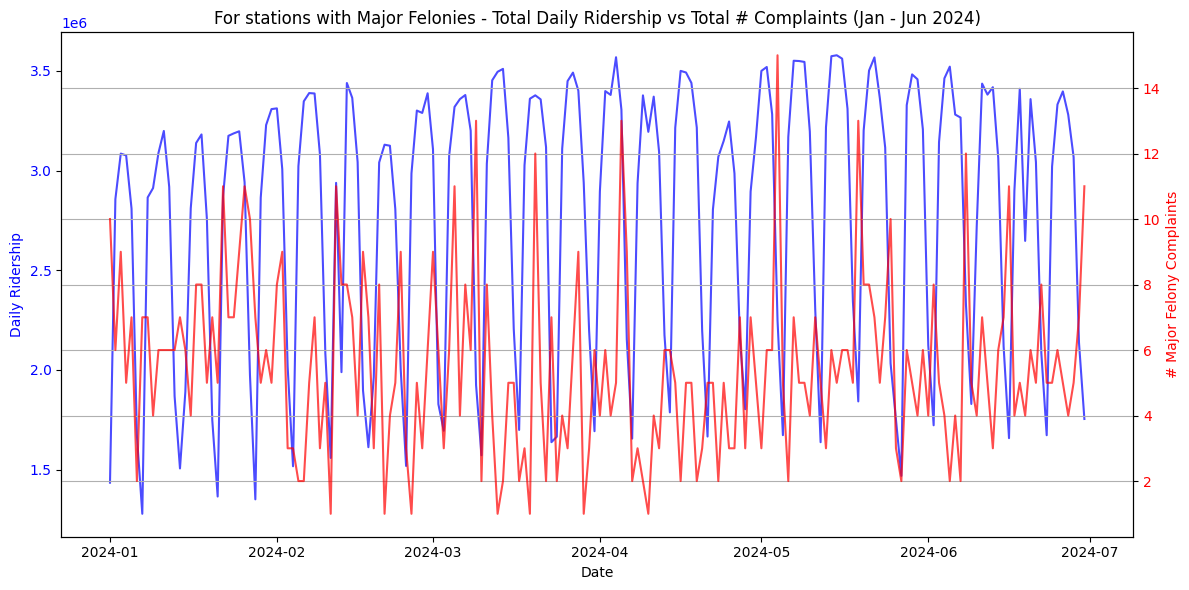

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os

google_drive_path = '/content/drive/MyDrive/'
ridership_data = pd.read_csv(os.path.join(google_drive_path, 'Comprehensive_Daily_Ridership.csv'))
complaint_data = pd.read_csv(os.path.join(google_drive_path, 'Complaint_Data_For_Major_Felonies.csv'))

ridership_data['date'] = pd.to_datetime(ridership_data['date'])
complaint_data['ridership_date'] = pd.to_datetime(complaint_data['ridership_date'], errors='coerce')

# Filtering complaints for major felonies
major_felonies = ['RAPE', 'ROBBERY', 'FELONY ASSAULT', 'BURGLARY', 'GRAND LARCENY']
major_felony_complaints = complaint_data[complaint_data['OFNS_DESC'].isin(major_felonies)]

# Extracting unique stations with such complaints
major_felony_stations = major_felony_complaints['mapped_ridership_station'].unique()

# Filtering ridership to include only these stations
ridership_filtered = ridership_data[
    ridership_data['cleaned_station'].isin(major_felony_stations)
]

ridership_filtered = ridership_filtered[
    (ridership_filtered['date'] >= '2024-01-01') & (ridership_filtered['date'] <= '2024-06-30')
]

# Aggregating daily riderships
daily_ridership_total = ridership_filtered.groupby('date')['daily_ridership'].sum()

# Aggregating total number of major felony complaints per ridership date
daily_major_felony_complaints = major_felony_complaints.groupby('ridership_date')['CMPLNT_NUM'].count()

overlay_data = pd.DataFrame({
    'Daily Ridership': daily_ridership_total,
    'Major Felony Complaints': daily_major_felony_complaints
}).fillna(0)

# Plot with dual axes
fig, ax1 = plt.subplots(figsize=(12, 6))

# Daily Ridership on first y-axis
ax1.plot(overlay_data.index, overlay_data['Daily Ridership'], label='Daily Ridership', color='blue', alpha=0.7)
ax1.set_xlabel('Date')
ax1.set_ylabel('Daily Ridership', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Major Felony Complaints on second y-axis
ax2 = ax1.twinx()
ax2.plot(overlay_data.index, overlay_data['Major Felony Complaints'], label='# Major Felony Complaints', color='red', alpha=0.7)
ax2.set_ylabel('# Major Felony Complaints', color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.title('For stations with Major Felonies - Total Daily Ridership vs Total # Complaints (Jan - Jun 2024)')
fig.tight_layout()
plt.grid(visible=True)

plt.show()

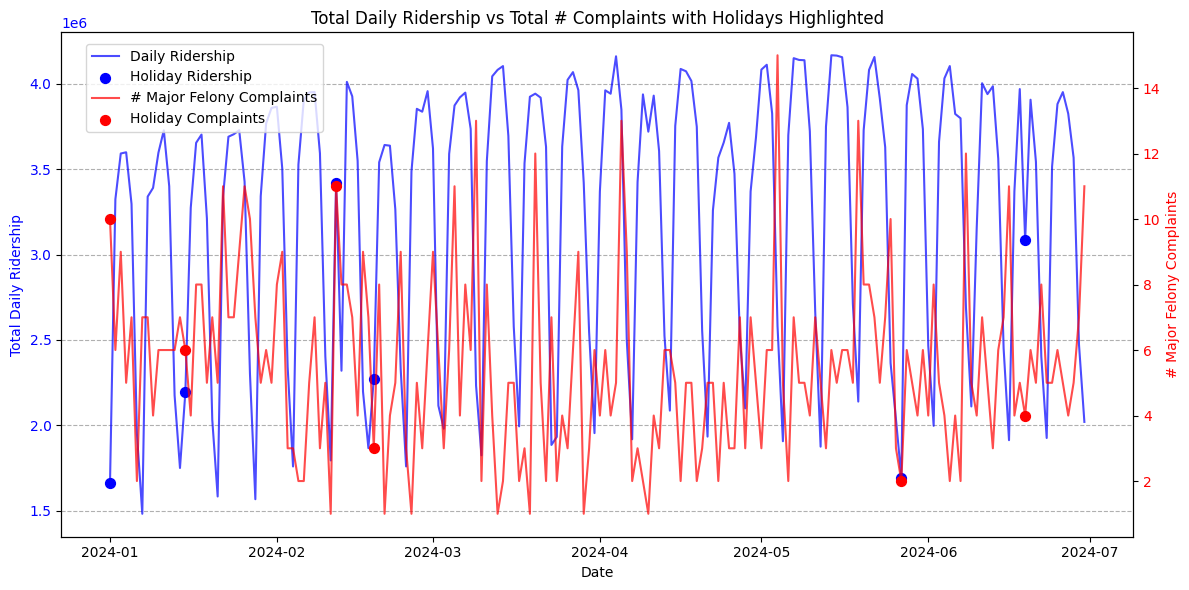

In [ ]:
ridership_data['date'] = pd.to_datetime(ridership_data['date'])
complaint_data['ridership_date'] = pd.to_datetime(complaint_data['ridership_date'], errors='coerce')

holidays = [
    '2024-01-01', '2024-01-15', '2024-02-12',
    '2024-02-19', '2024-05-27', '2024-06-19'
]
holidays = [pd.Timestamp(date) for date in holidays]

major_felonies = ['RAPE', 'ROBBERY', 'FELONY ASSAULT', 'BURGLARY', 'GRAND LARCENY']
major_felony_complaints = complaint_data[complaint_data['OFNS_DESC'].isin(major_felonies)]

# Aggregating daily ridership and complaints
daily_ridership_total = ridership_data.groupby('date')['daily_ridership'].sum()
daily_major_felony_complaints = major_felony_complaints.groupby('ridership_date')['CMPLNT_NUM'].count()

overlay_data = pd.DataFrame({
    'Daily Ridership': daily_ridership_total,
    'Major Felony Complaints': daily_major_felony_complaints
}).fillna(0)

# Marking holidays
overlay_data['Is Holiday'] = overlay_data.index.isin(holidays)
holiday_data = overlay_data[overlay_data['Is Holiday']]

fig, ax1 = plt.subplots(figsize=(12, 6))
# Daily Ridership on first y-axis
ax1.plot(overlay_data.index, overlay_data['Daily Ridership'], label='Daily Ridership', color='blue', alpha=0.7)
ax1.scatter(holiday_data.index, holiday_data['Daily Ridership'], color='blue', s=50, label='Holiday Ridership')
ax1.set_xlabel('Date')
ax1.set_ylabel('Total Daily Ridership', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Major Felony Complaints on second y-axis
ax2 = ax1.twinx()
ax2.plot(overlay_data.index, overlay_data['Major Felony Complaints'], label='# Major Felony Complaints', color='red', alpha=0.7)
ax2.scatter(holiday_data.index, holiday_data['Major Felony Complaints'], color='red', s=50, label='Holiday Complaints')
ax2.set_ylabel('# Major Felony Complaints', color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.title('Total Daily Ridership vs Total # Complaints with Holidays Highlighted')
fig.legend(loc="upper left", bbox_to_anchor=(0.07, 0.93))
ax1.yaxis.grid(True, linestyle='--')
plt.tight_layout()
plt.show()


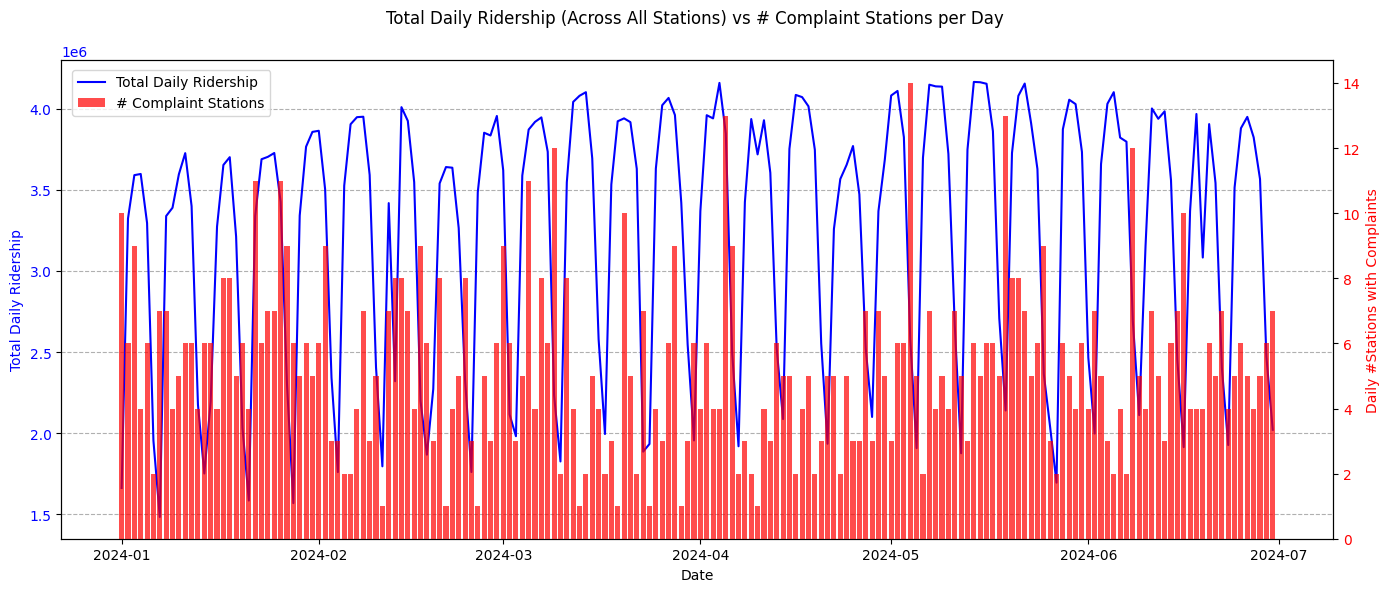

In [ ]:
ridership_data = pd.read_csv(os.path.join(google_drive_path, 'Comprehensive_Daily_Ridership.csv'))
complaint_data = pd.read_csv(os.path.join(google_drive_path, 'Complaint_Data_For_Major_Felonies.csv'))

complaint_data['ridership_date'] = pd.to_datetime(complaint_data['ridership_date'])
ridership_data['date'] = pd.to_datetime(ridership_data['date'])

start_date = '2024-01-01'
end_date = '2024-06-30'

filtered_complaint_data = complaint_data[
    (complaint_data['ridership_date'] >= start_date) &
    (complaint_data['ridership_date'] <= end_date)
]

filtered_ridership_data = ridership_data[
    (ridership_data['date'] >= start_date) &
    (ridership_data['date'] <= end_date)
]

# Calculating number of unique complaint stations per day
daily_complaint_stations = (
    filtered_complaint_data
    .groupby('ridership_date')['mapped_ridership_station']
    .nunique()
    .reset_index(name='num_complaint_stations')
)

# Calculating total daily ridership
daily_total_ridership = (
    filtered_ridership_data
    .groupby('date')['daily_ridership']
    .sum()
    .reset_index()
)

combined_data = pd.merge(
    daily_complaint_stations,
    daily_total_ridership,
    left_on='ridership_date',
    right_on='date',
    how='outer'
).fillna(0)

fig, ax1 = plt.subplots(figsize=(14, 6))

# Line plot for total ridership
ax1.plot(combined_data['ridership_date'], combined_data['daily_ridership'], color='blue', label='Total Daily Ridership')
ax1.set_xlabel('Date')
ax1.set_ylabel('Total Daily Ridership', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Bar plot for number of complaint stations
ax2 = ax1.twinx()
ax2.bar(combined_data['ridership_date'], combined_data['num_complaint_stations'], color='red', alpha=0.7, label='# Complaint Stations')
ax2.set_ylabel('Daily #Stations with Complaints', color='red')
ax2.tick_params(axis='y', labelcolor='red')

fig.suptitle('Total Daily Ridership (Across All Stations) vs # Complaint Stations per Day')
fig.tight_layout()

# Adjusting position of legend box
fig.legend(loc='upper left', bbox_to_anchor=(0.05, 0.89), bbox_transform=fig.transFigure)

ax1.yaxis.grid(True, linestyle='--')
plt.show()


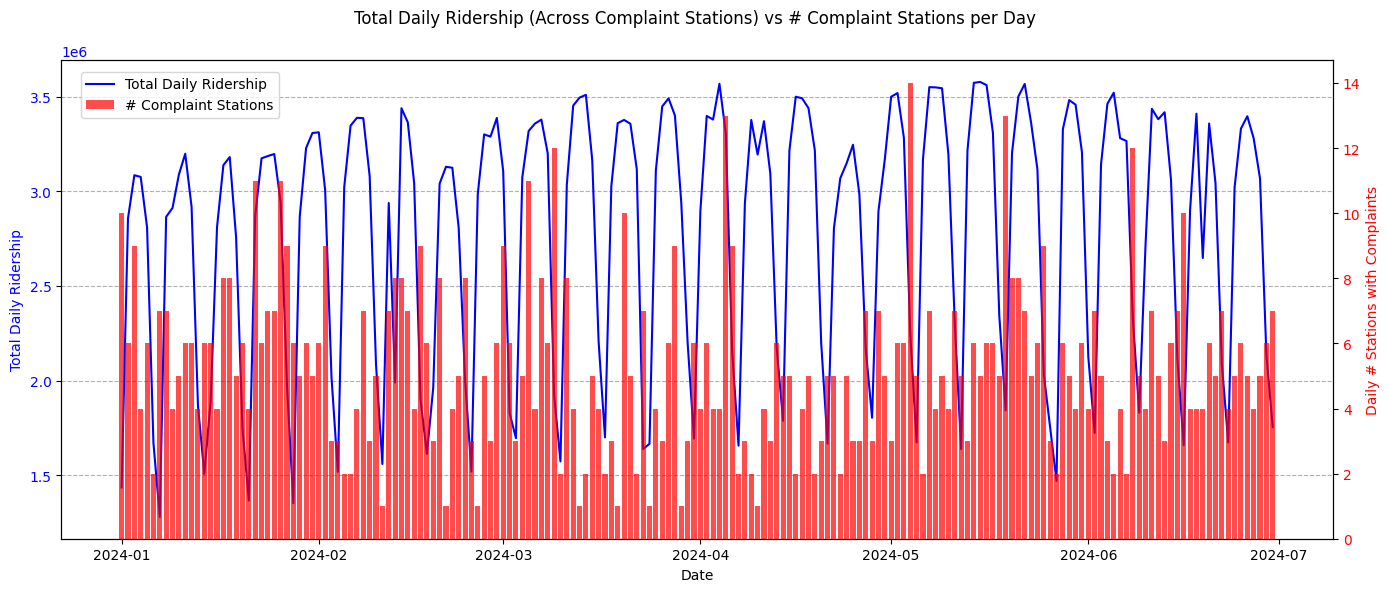

In [ ]:
complaint_data['ridership_date'] = pd.to_datetime(complaint_data['ridership_date'])
ridership_data['date'] = pd.to_datetime(ridership_data['date'])

start_date = '2024-01-01'
end_date = '2024-06-30'

filtered_complaint_data = complaint_data[
    (complaint_data['ridership_date'] >= start_date) &
    (complaint_data['ridership_date'] <= end_date)
]

filtered_ridership_data = ridership_data[
    (ridership_data['date'] >= start_date) &
    (ridership_data['date'] <= end_date)
]

complaint_stations = filtered_complaint_data['mapped_ridership_station'].unique()

# Filtering ridership data to include only complaint stations
ridership_complaint_stations = filtered_ridership_data[
    filtered_ridership_data['cleaned_station'].isin(complaint_stations)
]

# Calculating total ridership per day across complaint stations
daily_complaint_ridership = (
    ridership_complaint_stations
    .groupby('date')['daily_ridership']
    .sum()
    .reset_index(name='total_ridership_complaint_stations')
)

# Calculating number of unique complaint stations per day
daily_complaint_stations = (
    filtered_complaint_data
    .groupby('ridership_date')['mapped_ridership_station']
    .nunique()
    .reset_index(name='num_complaint_stations')
)

combined_data = pd.merge(
    daily_complaint_stations,
    daily_complaint_ridership,
    left_on='ridership_date',
    right_on='date',
    how='outer'
).fillna(0)

fig, ax1 = plt.subplots(figsize=(14, 6))

# Line plot for total ridership across complaint stations
ax1.plot(combined_data['ridership_date'], combined_data['total_ridership_complaint_stations'], color='blue', label='Total Daily Ridership')
ax1.set_xlabel('Date')
ax1.set_ylabel('Total Daily Ridership', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Bar plot for number of complaint stations
ax2 = ax1.twinx()
ax2.bar(combined_data['ridership_date'], combined_data['num_complaint_stations'], color='red', alpha=0.7, label='# Complaint Stations')
ax2.set_ylabel('Daily # Stations with Complaints', color='red')
ax2.tick_params(axis='y', labelcolor='red')

fig.suptitle('Total Daily Ridership (Across Complaint Stations) vs # Complaint Stations per Day')
fig.tight_layout()
fig.legend(loc='upper left', bbox_to_anchor=(0.01, 0.99), bbox_transform=ax1.transAxes)

ax1.yaxis.grid(True, linestyle='--')

plt.show()


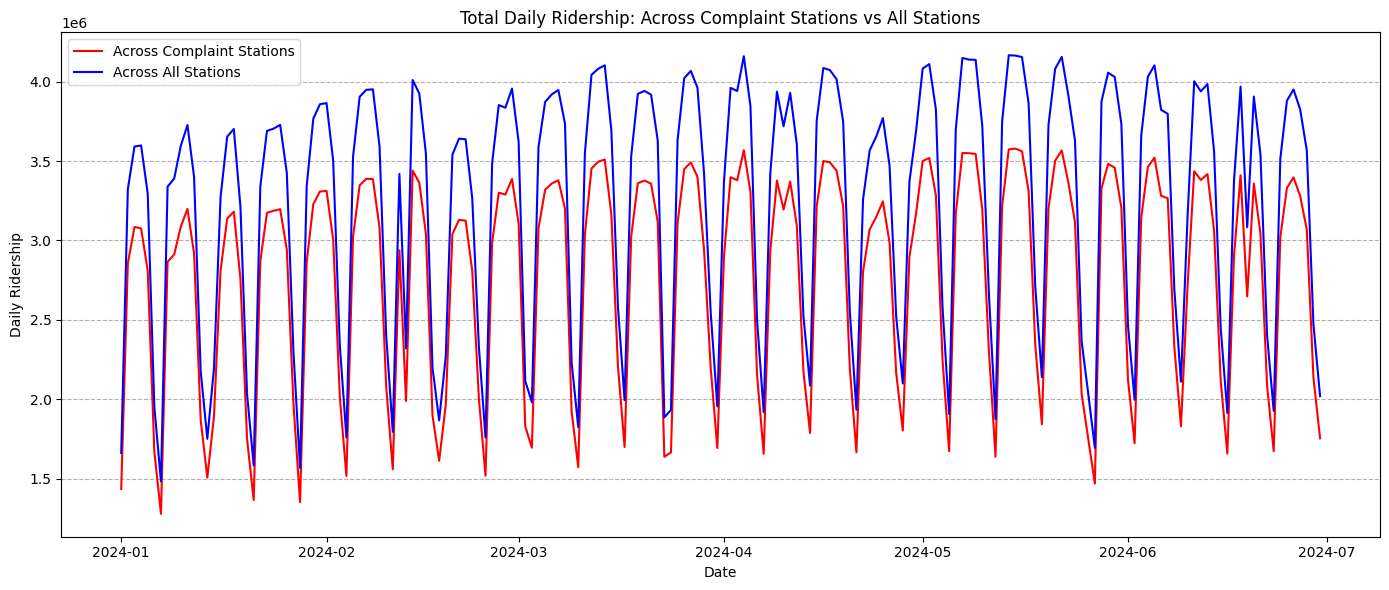

In [ ]:
complaint_data['ridership_date'] = pd.to_datetime(complaint_data['ridership_date'])
ridership_data['date'] = pd.to_datetime(ridership_data['date'])

start_date = '2024-01-01'
end_date = '2024-06-30'

filtered_complaint_data = complaint_data[
    (complaint_data['ridership_date'] >= start_date) &
    (complaint_data['ridership_date'] <= end_date)
]

filtered_ridership_data = ridership_data[
    (ridership_data['date'] >= start_date) &
    (ridership_data['date'] <= end_date)
]

complaint_stations = filtered_complaint_data['mapped_ridership_station'].unique()

ridership_complaint_stations = filtered_ridership_data[
    filtered_ridership_data['cleaned_station'].isin(complaint_stations)
]

daily_complaint_ridership = (
    ridership_complaint_stations
    .groupby('date')['daily_ridership']
    .sum()
    .reset_index()
    .rename(columns={'daily_ridership': 'total_ridership_complaint_stations'})
)

daily_total_ridership_all = (
    filtered_ridership_data
    .groupby('date')['daily_ridership']
    .sum()
    .reset_index()
    .rename(columns={'daily_ridership': 'total_ridership_all_stations'})
)

combined_ridership = pd.merge(
    daily_complaint_ridership,
    daily_total_ridership_all,
    on='date',
    how='left'
).fillna(0)

fig, ax = plt.subplots(figsize=(14, 6))

# Line plot for total ridership across complaint stations
ax.plot(combined_ridership['date'], combined_ridership['total_ridership_complaint_stations'], color='red', label='Across Complaint Stations')

# Line plot for total ridership across all stations
ax.plot(combined_ridership['date'], combined_ridership['total_ridership_all_stations'], color='blue', label='Across All Stations')

ax.set_xlabel('Date')
ax.set_ylabel('Daily Ridership')
ax.set_title('Total Daily Ridership: Across Complaint Stations vs All Stations')

ax.legend(loc='upper left')
plt.tight_layout()
ax.yaxis.grid(True, linestyle='--')
plt.show()


*On average, 85.9% of the total daily ridership in the system comes from stations with major felony complaints. Since felony station ridership accounts for a large share of it, the two plots above will look very similar.*

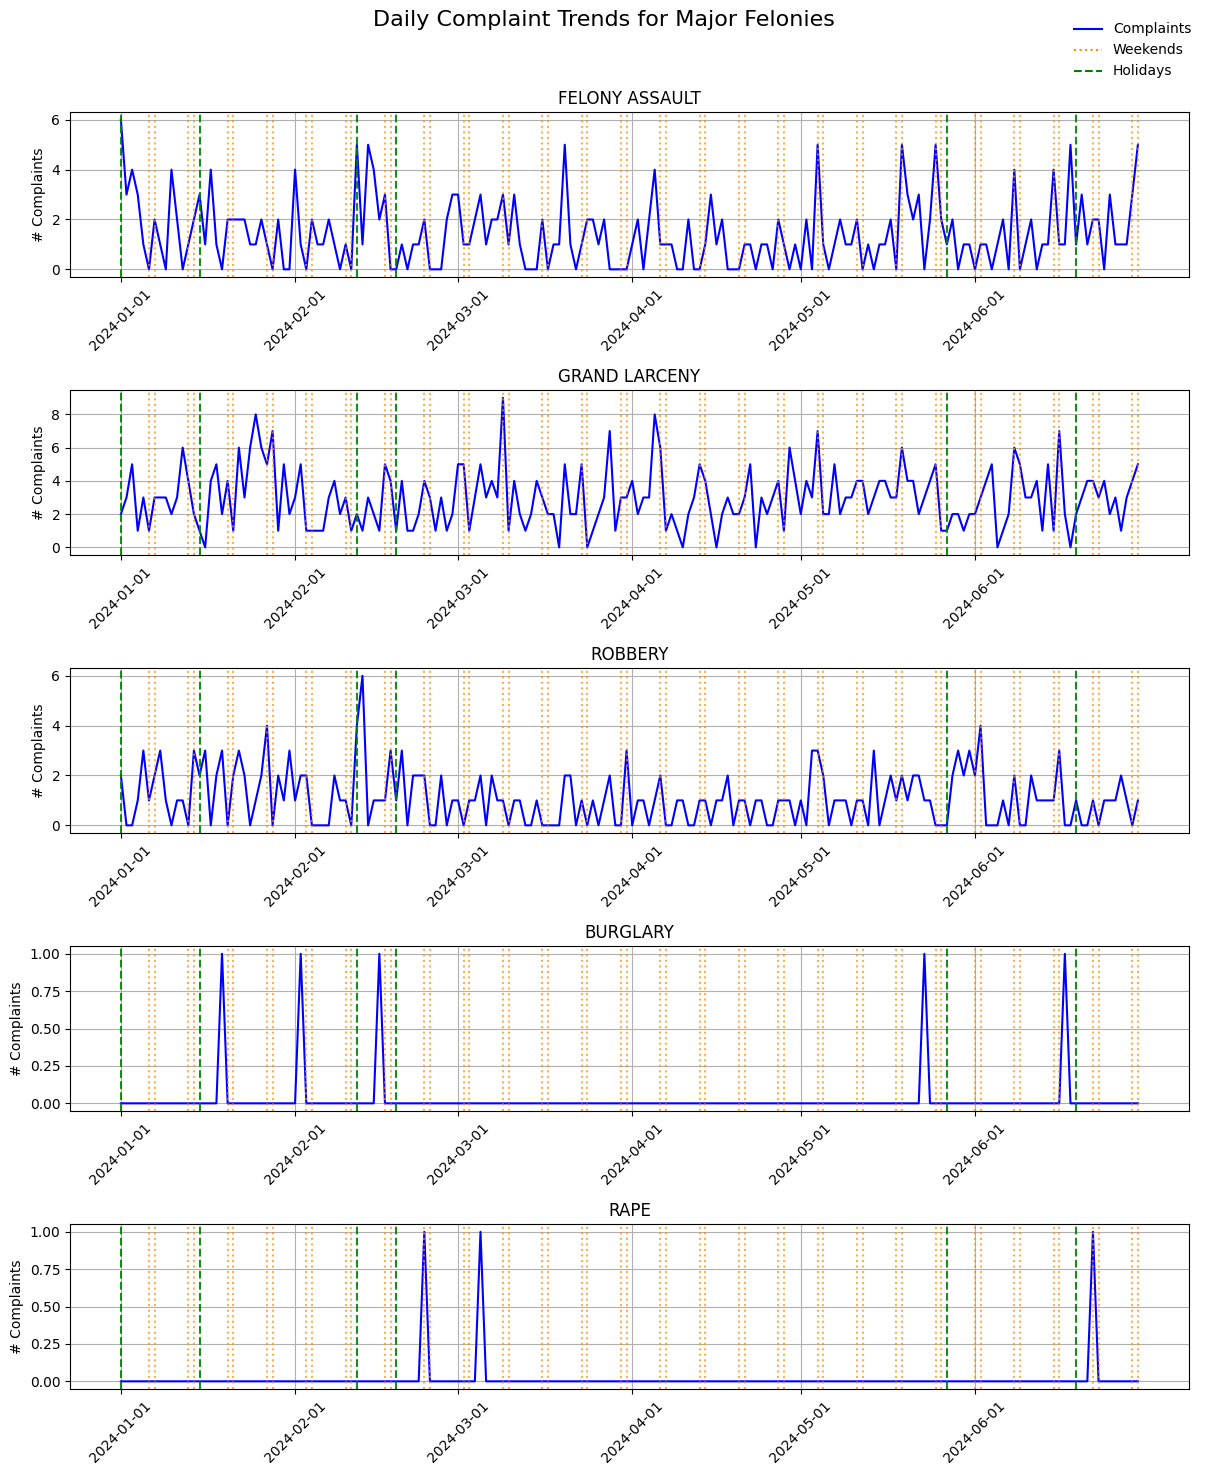

In [ ]:
ridership_data = pd.read_csv(os.path.join(google_drive_path, 'Comprehensive_Daily_Ridership.csv'))
complaint_data = pd.read_csv(os.path.join(google_drive_path, 'Complaint_Data_For_Major_Felonies.csv'))

complaint_data['CMPLNT_FR_DT'] = pd.to_datetime(complaint_data['CMPLNT_FR_DT'], errors='coerce')

filtered_data = complaint_data[(complaint_data['CMPLNT_FR_DT'] >= '2024-01-01') &
                                (complaint_data['CMPLNT_FR_DT'] <= '2024-06-30')]

# Aggregating daily complaints per major felony
daily_trend = filtered_data.groupby(['CMPLNT_FR_DT', 'OFNS_DESC']).size().reset_index(name='count')

# Creating date range and all felony types
full_dates = pd.date_range(start='2024-01-01', end='2024-06-30')
felonies = daily_trend['OFNS_DESC'].unique()
full_grid = pd.MultiIndex.from_product([full_dates, felonies], names=['CMPLNT_FR_DT', 'OFNS_DESC'])
full_data = pd.DataFrame(index=full_grid).reset_index()

# Merging and filling missing counts with 0
daily_trend_complete = pd.merge(full_data, daily_trend, on=['CMPLNT_FR_DT', 'OFNS_DESC'], how='left').fillna({'count': 0})

# Identifying weekends and holidays
weekends = full_dates[full_dates.weekday >= 5]
holidays = pd.to_datetime(['2024-01-01', '2024-01-15', '2024-02-12',
                           '2024-02-19', '2024-05-27', '2024-06-19'])

# Defining monthly ticks for x-axis
monthly_ticks = pd.date_range(start='2024-01-01', end='2024-06-30', freq='MS')


fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(12, 15), sharex=False)
fig.suptitle('Daily Complaint Trends for Major Felonies', fontsize=16)

for i, felony in enumerate(felonies):
    ax = axes[i]
    felony_data = daily_trend_complete[daily_trend_complete['OFNS_DESC'] == felony]
    ax.plot(felony_data['CMPLNT_FR_DT'], felony_data['count'], color='blue', label='Complaints')

    for weekend in weekends:
        ax.axvline(weekend, color='#FF8C00', linestyle=':', alpha=0.7)

    for holiday in holidays:
        ax.axvline(holiday, color='green', linestyle='--', alpha=0.9)

    ax.set_title(f'{felony}')
    ax.set_ylabel('# Complaints')
    ax.grid(True)
    # Setting one labeled date per month
    ax.set_xticks(monthly_ticks)
    ax.set_xticklabels(monthly_ticks.strftime('%Y-%m-%d'), rotation=45)

legend_lines = [
    plt.Line2D([0], [0], color='blue', label='Complaints'),
    plt.Line2D([0], [0], color='#FF8C00', linestyle=':', label='Weekends'),
    plt.Line2D([0], [0], color='green', linestyle='--', label='Holidays')
]
fig.legend(handles=legend_lines, loc='upper right', bbox_to_anchor=(1, 0.98), frameon=False, fontsize=10)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


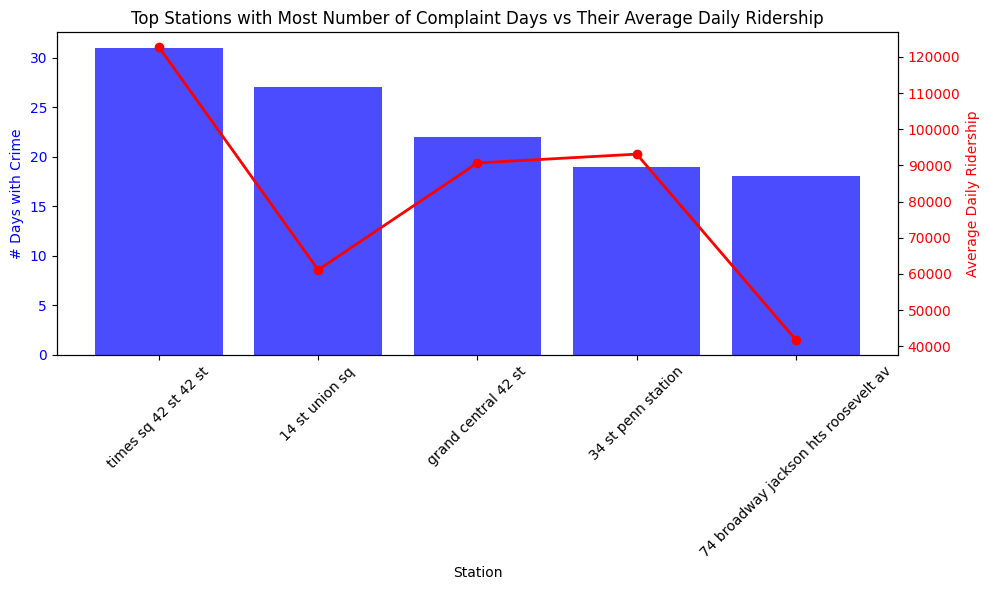

In [ ]:
ridership_data = pd.read_csv(os.path.join(google_drive_path, 'Comprehensive_Daily_Ridership.csv'))
complaint_data = pd.read_csv(os.path.join(google_drive_path, 'Complaint_Data_For_Major_Felonies.csv'))

complaint_data['CMPLNT_FR_DT'] = pd.to_datetime(complaint_data['CMPLNT_FR_DT'], errors='coerce')

filtered_complaint_data = complaint_data[
    (complaint_data['CMPLNT_FR_DT'] >= '2024-01-01') &
    (complaint_data['CMPLNT_FR_DT'] <= '2024-06-30')
]

# Grouping complaints by station to get total number of days with complaints
crime_days = filtered_complaint_data.groupby('mapped_ridership_station')['CMPLNT_FR_DT'].nunique().reset_index(name='Days with Crime')

# Top 5 stations with most number of complaint days
top_stations = crime_days.nlargest(5, 'Days with Crime')['mapped_ridership_station'].unique()

ridership_data['date'] = pd.to_datetime(ridership_data['date'], errors='coerce')

# Filtering ridership data for top stations
filtered_ridership = ridership_data[
    (ridership_data['date'] >= '2024-01-01') &
    (ridership_data['date'] <= '2024-06-30') &
    (ridership_data['cleaned_station'].isin(top_stations))
]

# Calculating average daily ridership
total_ridership = filtered_ridership.groupby('cleaned_station')['daily_ridership'].sum().reset_index(name='Total Ridership')
total_ridership['Average Daily Ridership'] = total_ridership['Total Ridership'] / 182

plot_data = crime_days.merge(total_ridership, left_on='mapped_ridership_station', right_on='cleaned_station')
plot_data = plot_data.drop(columns='cleaned_station').sort_values(by='Days with Crime', ascending=False)

fig, ax1 = plt.subplots(figsize=(10, 6))

# Bar plot for total number of days with crime
ax1.bar(plot_data['mapped_ridership_station'], plot_data['Days with Crime'], color='blue', alpha=0.7)
ax1.set_xlabel('Station')
ax1.set_ylabel('# Days with Crime', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
plt.xticks(rotation=45)

# Line plot for average daily ridership
ax2 = ax1.twinx()
ax2.plot(plot_data['mapped_ridership_station'], plot_data['Average Daily Ridership'], color='red', marker='o', linestyle='-', linewidth=2)
ax2.set_ylabel('Average Daily Ridership', color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.title( 'Top Stations with Most Number of Complaint Days vs Their Average Daily Ridership')
plt.tight_layout()
plt.show()


In [ ]:
!pip install statsmodels

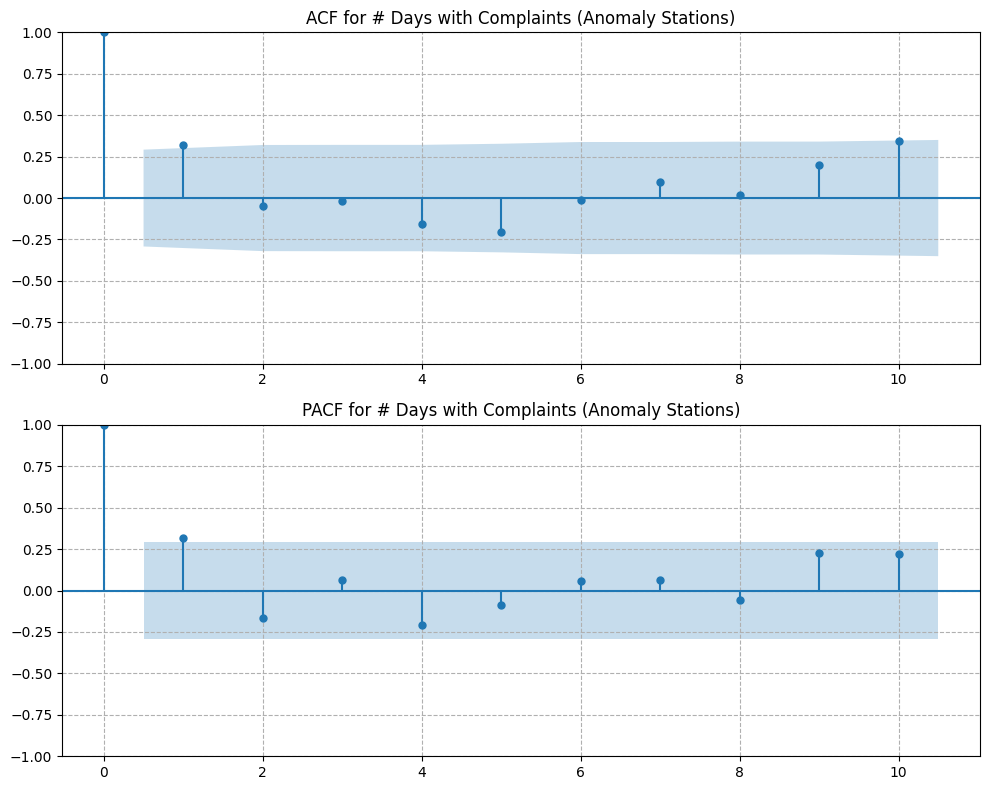

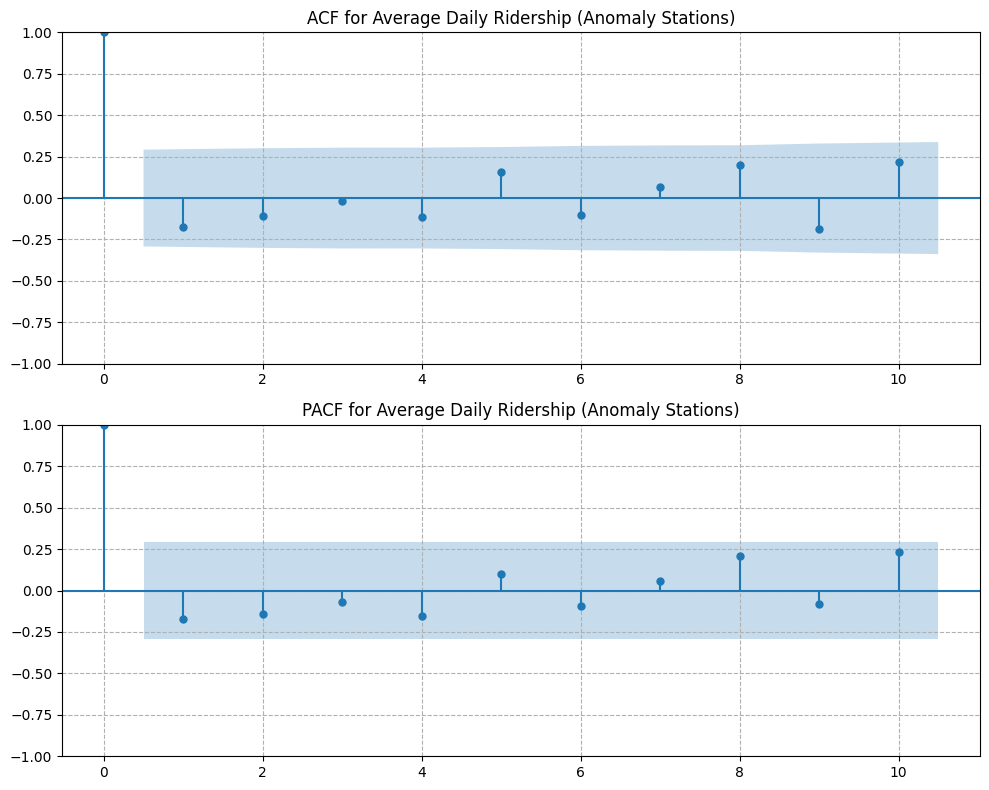

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import statsmodels.api as sm

google_drive_path = '/content/drive/MyDrive/'
complaints_data = pd.read_csv(os.path.join(google_drive_path, 'renamed_complaints.csv'))

# Filter data for anomaly stations
anomaly_stations = ["14 st union sq", "74 broadway jackson hts roosevelt av"]
anomaly_data = complaints_data[complaints_data['station_name'].isin(anomaly_stations)]

# Group and calculate total # days with complaints for anomaly stations
anomaly_complaints = anomaly_data.groupby('ridership_date').size().reset_index(name='complaints')
anomaly_complaints['ridership_date'] = pd.to_datetime(anomaly_complaints['ridership_date'])

# Get average daily ridership for anomaly stations
anomaly_ridership = anomaly_data[['ridership_date', 'daily_ridership']].drop_duplicates()
anomaly_ridership['ridership_date'] = pd.to_datetime(anomaly_ridership['ridership_date'])

# Merge anomaly complaints and ridership by date
anomaly_merged = pd.merge(
    anomaly_complaints,
    anomaly_ridership,
    on='ridership_date',
    how='inner'
).sort_values('ridership_date')

# Extract time series for autocorrelation analysis
anomaly_complaints_ts = anomaly_merged['complaints'].values
anomaly_ridership_ts = anomaly_merged['daily_ridership'].values

# Perform autocorrelation analysis for complaints and ridership
fig, axes = plt.subplots(2, 1, figsize=(10, 8))
sm.graphics.tsa.plot_acf(anomaly_complaints_ts, lags=10, ax=axes[0], title="ACF for # Days with Complaints (Anomaly Stations)")
sm.graphics.tsa.plot_pacf(anomaly_complaints_ts, lags=10, ax=axes[1], title="PACF for # Days with Complaints (Anomaly Stations)")
plt.tight_layout()
axes[0].grid(True, linestyle='--')
axes[1].grid(True, linestyle='--')
plt.show()

fig, axes = plt.subplots(2, 1, figsize=(10, 8))
sm.graphics.tsa.plot_acf(anomaly_ridership_ts, lags=10, ax=axes[0], title="ACF for Average Daily Ridership (Anomaly Stations)")
sm.graphics.tsa.plot_pacf(anomaly_ridership_ts, lags=10, ax=axes[1], title="PACF for Average Daily Ridership (Anomaly Stations)")
plt.tight_layout()
axes[0].grid(True, linestyle='--')
axes[1].grid(True, linestyle='--')
plt.show()



## Arrest data analysis:

**Matching arrest locations from NYPD reports to MTA station locations:**

In [ ]:
import pandas as pd
from geopy.distance import geodesic

In [ ]:
pip install scikit-learn

In [ ]:
from sklearn.neighbors import BallTree
import numpy as np

In [ ]:
# Loading data
crime_data = pd.read_csv('new_crime_locations.csv')
station_data = pd.read_csv('subway_station_locations.csv')

**Data Preview:**

In [ ]:
crime_data.head()

,ARREST_KEY,ARREST_DATE,PD_CD,PD_DESC,KY_CD,OFNS_DESC,LAW_CODE,LAW_CAT_CD,ARREST_BORO,ARREST_PRECINCT,JURISDICTION_CODE,AGE_GROUP,PERP_SEX,PERP_RACE,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,New Georeferenced Column
0,280000766,01/05/2024,339,"LARCENY,PETIT FROM OPEN AREAS,",341,PETIT LARCENY,PL 1552500,M,Q,109,1,45-64,M,WHITE HISPANIC,1031307,216054,40.759570,-73.830139,POINT (-73.83013930521312 40.759569525960025)
1,282118307,02/13/2024,339,"LARCENY,PETIT FROM OPEN AREAS,",341,PETIT LARCENY,PL 1552500,M,M,5,1,25-44,M,WHITE HISPANIC,983903,200257,40.716337,-74.001251,POINT (-74.001251 40.716337)
2,280752499,01/18/2024,478,"THEFT OF SERVICES, UNCLASSIFIE",343,OTHER OFFENSES RELATED TO THEF,PL 1651503,M,K,79,1,25-44,M,WHITE HISPANIC,996546,187436,40.681137,-73.955668,POINT (-73.9556676077586 40.6811367070632)
3,281609164,02/03/2024,101,ASSAULT 3,344,ASSAULT 3 & RELATED OFFENSES,PL 1200001,M,K,84,1,25-44,M,BLACK,990141,188391,40.683765,-73.978760,POINT (-73.97875956361523 40.68376454457041)
4,281588946,02/03/2024,115,RECKLESS ENDANGERMENT 2,355,OFFENSES AGAINST THE PERSON,PL 1202000,M,Q,109,1,18-24,M,BLACK HISPANIC,1031307,216054,40.759570,-73.830139,POINT (-73.83013930521312 40.759569525960025)


In [ ]:
station_data.head()

,GTFS Stop ID,Station ID,Complex ID,Division,Line,Stop Name,Borough,CBD,Daytime Routes,Structure,GTFS Latitude,GTFS Longitude,North Direction Label,South Direction Label,ADA,ADA Northbound,ADA Southbound,ADA Notes,Georeference
0,R01,1,1,BMT,Astoria,Astoria-Ditmars Blvd,Q,False,N W,Elevated,40.775036,-73.912034,Last Stop,Manhattan,0,0,0,NaN,POINT (-73.912034 40.775036)
1,R03,2,2,BMT,Astoria,Astoria Blvd,Q,False,N W,Elevated,40.770258,-73.917843,Astoria,Manhattan,1,1,1,NaN,POINT (-73.917843 40.770258)
2,R04,3,3,BMT,Astoria,30 Av,Q,False,N W,Elevated,40.766779,-73.921479,Astoria,Manhattan,0,0,0,NaN,POINT (-73.921479 40.766779)
3,R05,4,4,BMT,Astoria,Broadway,Q,False,N W,Elevated,40.761820,-73.925508,Astoria,Manhattan,0,0,0,NaN,POINT (-73.925508 40.76182)
4,R06,5,5,BMT,Astoria,36 Av,Q,False,N W,Elevated,40.756804,-73.929575,Astoria,Manhattan,0,0,0,NaN,POINT (-73.929575 40.756804)


**Types of Crimes and their Counts**

In [ ]:
debug_crime=pd.read_csv('new_crime_locations.csv')
count=debug_crime['OFNS_DESC'].value_counts()
print(count)

OFNS_DESC
OTHER OFFENSES RELATED TO THEFT     4066
DANGEROUS WEAPONS                    686
OTHER STATE LAWS                     609
DANGEROUS DRUGS                      603
OFFENSES AGAINST PUBLIC ADMINI       423
ASSAULT 3 & RELATED OFFENSES         388
CRIMINAL MISCHIEF & RELATED OF       378
CRIMINAL TRESPASS                    232
FORGERY                              189
FELONY ASSAULT                       151
MISCELLANEOUS PENAL LAW              126
SEX CRIMES                           122
FRAUDS                               112
PETIT LARCENY                         92
GRAND LARCENY                         83
OFFENSES AGAINST THE PERSON           74
ROBBERY                               66
POSSESSION OF STOLEN PROPERTY         60
OFF. AGNST PUB ORD SENSBLTY &         56
JOSTLING                              39
OFFENSES INVOLVING FRAUD              35
BURGLAR'S TOOLS                       25
ADMINISTRATIVE CODE                   23
OTHER STATE LAWS (NON PENAL LAW)      14
DISORD

In [ ]:
# Extract latitudes and longitudes, and convert them to radians (for BallTree)
crime_coords = np.radians(crime_data[['Latitude', 'Longitude']].values)
station_coords = np.radians(station_data[['GTFS Latitude', 'GTFS Longitude']].values)

# BallTree for fast nearest neighbor search
station_tree = BallTree(station_coords, metric='haversine')

# Searching
distances, indices = station_tree.query(crime_coords, k=1)

# Converting distances from radians to meters (Haversine formula gives radians)
earth_radius = 6371000
distances_in_meters = distances * earth_radius

# Adding nearest station and distance information to crime data
crime_data['nearest_station'] = station_data.iloc[indices.flatten()]['Stop Name'].values
crime_data['nearest_station_latitude'] = station_data.iloc[indices.flatten()]['GTFS Latitude'].values
crime_data['nearest_station_longitude'] = station_data.iloc[indices.flatten()]['GTFS Longitude'].values
crime_data['distance_to_station'] = distances_in_meters.flatten()

# Setting a threshold (in meters) for matching
distance_threshold = 4938.817877 #Set to random initially but later to the actual max value obtained from the next step
matched_crimes = crime_data[crime_data['distance_to_station'] <= distance_threshold]

**Checking the largest distance of a crime location to its nearest subway station:**

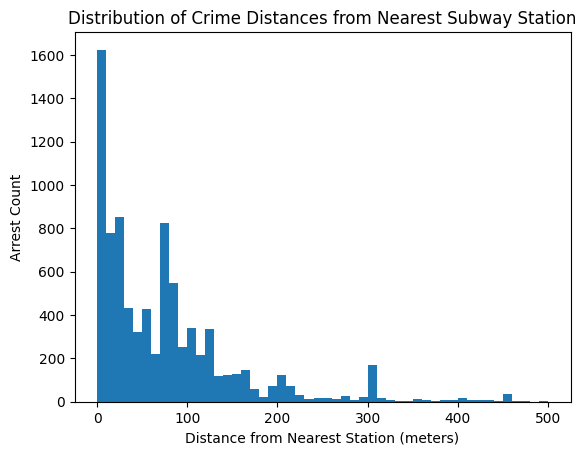

The largest distance from a station is 4938.82 meters.
Details of the crime farthest from that station:
ARREST_KEY                                        282969513
ARREST_DATE                                      02/29/2024
PD_CD                                                   339
PD_DESC                      LARCENY,PETIT FROM OPEN AREAS,
KY_CD                                                   341
OFNS_DESC                                     PETIT LARCENY
LAW_CODE                                         PL 1552500
LAW_CAT_CD                                                M
ARREST_BORO                                               S
ARREST_PRECINCT                                         121
JURISDICTION_CODE                                         1
AGE_GROUP                                             25-44
PERP_SEX                                                  M
PERP_RACE                                             BLACK
X_COORD_CD                                           947

In [ ]:
import matplotlib.pyplot as plt

# Plotting distribution of distances
plt.hist(crime_data['distance_to_station'], bins=50, range=(0, 500))
plt.xlabel('Distance from Nearest Station (meters)')
plt.ylabel('Arrest Count')
plt.title('Distribution of Crime Distances from Nearest Subway Station')
plt.show()
max_distance = crime_data['distance_to_station'].max()

# Max distance
print(f"The largest distance from a station is {max_distance:.2f} meters.")

# Crime details
crime_with_max_distance = crime_data.loc[crime_data['distance_to_station'].idxmax()]
print("Details of the crime farthest from that station:")
print(crime_with_max_distance)

*Most crime locations are within 500 meters from their nearest subway stations. The largest distance is 4938.817877 meters (~3 miles) for the Grasmere station in Staten Island*

In [ ]:
matched_crimes.to_csv("new_subway_crime.csv", index=False)

**Checking if all crimes from *new_crime_locations.csv* have been captured:**

In [ ]:
debug_crime=pd.read_csv('new_subway_crime.csv')
count=debug_crime['OFNS_DESC'].value_counts()
print(count)

OFNS_DESC
OTHER OFFENSES RELATED TO THEFT     4066
DANGEROUS WEAPONS                    686
OTHER STATE LAWS                     609
DANGEROUS DRUGS                      603
OFFENSES AGAINST PUBLIC ADMINI       423
ASSAULT 3 & RELATED OFFENSES         387
CRIMINAL MISCHIEF & RELATED OF       378
CRIMINAL TRESPASS                    232
FORGERY                              189
FELONY ASSAULT                       151
MISCELLANEOUS PENAL LAW              126
SEX CRIMES                           122
FRAUDS                               112
PETIT LARCENY                         92
GRAND LARCENY                         83
OFFENSES AGAINST THE PERSON           74
ROBBERY                               66
POSSESSION OF STOLEN PROPERTY         60
OFF. AGNST PUB ORD SENSBLTY &         56
JOSTLING                              39
OFFENSES INVOLVING FRAUD              35
BURGLAR'S TOOLS                       25
ADMINISTRATIVE CODE                   23
OTHER STATE LAWS (NON PENAL LAW)      14
DISORD

**Downloading 12 million rows of hourly subway ridership data via API:**

In [ ]:
import requests
import pandas as pd
import io
from concurrent.futures import ThreadPoolExecutor, as_completed

# Base query without limit and offset
base_query = (
    "SELECT `transit_timestamp`, `station_complex_id`, `station_complex`, `ridership`, `latitude`, `longitude` "
    "WHERE (`transit_timestamp` BETWEEN '2024-01-01T00:00:00'::floating_timestamp AND '2024-06-30T23:45:00'::floating_timestamp) "
    "AND caseless_eq(`transit_mode`, 'subway') "
    "ORDER BY `transit_timestamp` ASC NULL LAST "
)

# Parameters
limit = 50000  # Number of rows per request
total_rows = 12891907  # Approximate total number of rows
all_data = []

# Function to fetch a single batch of data
def fetch_data(offset):

    query = f"{base_query} LIMIT {limit} OFFSET {offset}"
    url = f"https://data.ny.gov/resource/wujg-7c2s.csv?$query={query}"
    response = requests.get(url)

    if response.status_code == 200:
        # Converting response text to DataFrame
        chunk = pd.read_csv(io.StringIO(response.text))
        return chunk
    else:
        print(f"Failed to fetch data at offset {offset}. Status code: {response.status_code}")
        return pd.DataFrame()  # Return empty on failure

# Using ThreadPoolExecutor to fetch data in parallel
with ThreadPoolExecutor(max_workers=5) as executor:

    offsets = range(0, total_rows, limit)
    futures = [executor.submit(fetch_data, offset) for offset in offsets]

    for future in as_completed(futures):
        data_chunk = future.result()
        if not data_chunk.empty:
            all_data.append(data_chunk)
            print(f"Fetched {sum(len(chunk) for chunk in all_data)} rows so far...")

# Combining
df = pd.concat(all_data, ignore_index=True)
print("All data downloaded. Total rows:", len(df))

df.to_csv("subway_hourly_ridership.csv", index=False)


*Ridership information for Staten Island stations was ommitted by mistake while downloading.*

**Combining Staten Island hourly ridership data (downloaded separately) with the rest**

In [ ]:
ridership_data = pd.read_csv('subway_hourly_ridership.csv')
staten_island_ridership = pd.read_csv('staten_island_ridership.csv')

# Converting 'transit_timestamp' to consistent format in st_george_ridership
staten_island_ridership['transit_timestamp'] = pd.to_datetime(
    staten_island_ridership['transit_timestamp'],
    format="%m/%d/%Y %I:%M:%S %p",  # Convert from 'MM/DD/YYYY hh:mm:ss AM/PM' format
    errors='coerce'
).dt.strftime('%Y-%m-%dT%H:%M:%S.%f')  # Format to match ridership_data

# Converting 'transit_timestamp' in ridership_data to a consistent format
ridership_data['transit_timestamp'] = pd.to_datetime(
    ridership_data['transit_timestamp'],
    errors='coerce'
).dt.strftime('%Y-%m-%dT%H:%M:%S.%f')

# Ensuring 'ridership' column is float
staten_island_ridership['ridership'] = staten_island_ridership['ridership'].astype(float)
ridership_data['ridership'] = ridership_data['ridership'].astype(float)

# Appending st_george_ridership to ridership_data
combined_data = pd.concat([ridership_data, staten_island_ridership], ignore_index=True)

In [ ]:
combined_data = combined_data.drop(columns=['transit_mode', 'borough','payment_method','fare_class_category','transfers','Georeference'])
combined_data.tail(2000)

,transit_timestamp,station_complex_id,station_complex,ridership,latitude,longitude,date
12942404,2024-01-21T19:00:00.000000,501,St George (SIR),4.0,40.643750,-74.07365,2024-01-21
12942405,2024-01-21T11:00:00.000000,501,St George (SIR),4.0,40.643750,-74.07365,2024-01-21
12942406,2024-01-21T15:00:00.000000,501,St George (SIR),6.0,40.643750,-74.07365,2024-01-21
12942407,2024-01-21T14:00:00.000000,501,St George (SIR),2.0,40.643750,-74.07365,2024-01-21
12942408,2024-01-21T03:00:00.000000,501,St George (SIR),3.0,40.643750,-74.07365,2024-01-21
...,...,...,...,...,...,...,...
12944399,2024-06-02T18:00:00.000000,502,Tompkinsville (SIR),3.0,40.636948,-74.07484,2024-06-02
12944400,2024-06-02T16:00:00.000000,501,St George (SIR),11.0,40.643750,-74.07365,2024-06-02
12944401,2024-06-02T23:00:00.000000,501,St George (SIR),5.0,40.643750,-74.07365,2024-06-02
12944402,2024-06-02T23:00:00.000000,501,St George (SIR),3.0,40.643750,-74.07365,2024-06-02


In [ ]:
# Finding all distinct values in the 'station_complex' column containing (SIR)
distinct_values = combined_data[combined_data['station_complex'].str.contains(r'\(SIR\)', na=False)]['station_complex'].unique()
print(distinct_values)

['Tompkinsville (SIR)' 'St George (SIR)']


*So, ridership information for Grasmere station is missing in the data source.*

In [ ]:
combined_data.to_csv('new_new_hourly_ridership.csv', index=False)

**Converting hourly ridership to daily ridership:**

In [ ]:
combined_data = pd.read_csv('new_new_hourly_ridership.csv')

# Ensuring 'transit_timestamp' is in datetime format and extracting the date
combined_data['date'] = pd.to_datetime(combined_data['transit_timestamp'], errors='coerce').dt.date

# Grouping by station information and date, then summing up ridership for daily values
daily_ridership = combined_data.groupby(
    ['station_complex_id', 'station_complex', 'latitude', 'longitude', 'date']
).agg({'ridership': 'sum'}).reset_index()

daily_ridership.rename(columns={'ridership': 'daily_ridership'}, inplace=True)

In [ ]:
daily_ridership.head(10)

,station_complex_id,station_complex,latitude,longitude,date,daily_ridership
0,1,"Astoria-Ditmars Blvd (N,W)",40.775036,-73.91203,2024-01-01,3719.0
1,1,"Astoria-Ditmars Blvd (N,W)",40.775036,-73.91203,2024-01-02,10141.0
2,1,"Astoria-Ditmars Blvd (N,W)",40.775036,-73.91203,2024-01-03,11036.0
3,1,"Astoria-Ditmars Blvd (N,W)",40.775036,-73.91203,2024-01-04,11111.0
4,1,"Astoria-Ditmars Blvd (N,W)",40.775036,-73.91203,2024-01-05,10394.0
5,1,"Astoria-Ditmars Blvd (N,W)",40.775036,-73.91203,2024-01-06,4218.0
6,1,"Astoria-Ditmars Blvd (N,W)",40.775036,-73.91203,2024-01-07,2759.0
7,1,"Astoria-Ditmars Blvd (N,W)",40.775036,-73.91203,2024-01-08,10165.0
8,1,"Astoria-Ditmars Blvd (N,W)",40.775036,-73.91203,2024-01-09,10335.0
9,1,"Astoria-Ditmars Blvd (N,W)",40.775036,-73.91203,2024-01-10,11285.0


In [ ]:
# Checking if st george station is in the dataset
is_in_column = daily_ridership['station_complex'].isin(['Tompkinsville (SIR)']).any()

print(is_in_column)

True


In [ ]:
daily_ridership.to_csv('new_daily_ridership.csv', index=False)

**Matching the nearest station locations from crime reports to station locations from daily ridership data:**

In [ ]:
!pip install rapidfuzz
import re
from rapidfuzz import process, fuzz
from geopy.distance import geodesic
import numpy as np

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 23.8 MB/s eta 0:00:00


In [ ]:
crime_data = pd.read_csv('new_subway_crime.csv')
daily_ridership = pd.read_csv('new_daily_ridership.csv')

crime_data['crime_date'] = pd.to_datetime(crime_data['ARREST_DATE']).dt.date
daily_ridership['date'] = pd.to_datetime(daily_ridership['date']).dt.date

# Function for cleaning station names
def clean_station_name(name):
    # Removing anything in parentheses and special characters
    name = re.sub(r'\(.*?\)', '', name)
    # Replacing hyphens, slashes, and extra whitespace
    name = re.sub(r'[-/]', ' ', name)
    name = re.sub(r'\s+', ' ', name)
    name = name.replace('&', 'and')  # Replacing '&' with 'and'
    return name.strip().lower()  # Converting to lowercase for case-insensitive matching

# Cleaning both station names
daily_ridership['cleaned_station'] = daily_ridership['station_complex'].apply(clean_station_name)
crime_data['cleaned_station'] = crime_data['nearest_station'].apply(clean_station_name)

# Function to calculate distance between two latitude-longitude points
def calculate_distance(lat1, lon1, lat2, lon2):
    return geodesic((lat1, lon1), (lat2, lon2)).km


# Fuzzy matching function to check for exact matches first, then fuzzy match, and finally check the distance
def fuzzy_match_crime_to_ridership_with_location(
        crime_stations, crime_latitudes, crime_longitudes,
        ridership_stations, ridership_latitudes, ridership_longitudes,
        fuzzy_threshold=80, location_threshold=0.5):
    match_dict = {}
    low_confidence_matches = []  # List for low confidence matches

    # Manual station mappings based on your request
    manual_mappings = {
        'cortlandt st': 'wtc cortlandt',
        'times sq 42 st': 'times sq 42 st 42 st',
        'park place': 'park pl',
        'brooklyn bridge city hall': 'brooklyn bridge city hall chambers st',
        '6 av':'14 st 6 av',
        '74 st broadway':'74 broadway jackson hts roosevelt av',
        'jackson hts roosevelt av':'74 broadway jackson hts roosevelt av',
        '14 st':'14 st 8 av',
        'lexington av 53 st':'lexington av 53 st 51 st',
        '42 st port authority bus terminal':'times sq 42 st 42 st',
        'franklin av medgar evers college':'franklin av botanic garden',
        'bleecker st':'broadway lafayette st bleecker st',
        '51 st':'lexington av 53 st 51 st',
        '62 st':'new utrecht av 62 st',
        'borough hall':'court st borough hall',
        'broadway lafayette st': 'broadway lafayette st bleecker st',
        '42 st bryant pk': 'bryant pk 5 av',
        'metropolitan av': 'lorimer st metropolitan av',
        'court sq 23 st': 'court sq',
        'botanic garden': 'franklin av botanic garden',
        'whitehall st south ferry': 'south ferry whitehall st',
        'south ferry': 'south ferry whitehall st',
        'christopher st stonewall': 'christopher st sheridan sq',
        'court st':'court st borough hall',
    }

    # List of stations to exclude from fuzzy matching and treat as standalone stations
    standalone_stations = ['east broadway','president st medgar evers college','grasmere']

    for i, crime_station in enumerate(crime_stations):

        # First check if crime station is a known standalone station
        if clean_station_name(crime_station) in [clean_station_name(station) for station in standalone_stations]:
            if crime_station in ridership_stations:
                match_dict[crime_station] = crime_station
                print(f"Exact match found for standalone station: '{crime_station}'")
            else:
                match_dict[crime_station] = None  # No match found
                print(f"No match found for standalone station: '{crime_station}'")
            continue  # Skipping fuzzy matching for known standalone stations

       # Checking for manual mapping
        mapped_station = manual_mappings.get(clean_station_name(crime_station))

        if mapped_station:

            if mapped_station in ridership_stations:
                match_dict[crime_station] = mapped_station
                print(f"Manual match: '{crime_station}' mapped to '{mapped_station}'")
            else:
                match_dict[crime_station] = None  # No match found
                print(f"No match found for manual mapping: '{crime_station}' to '{mapped_station}'")
            continue  # Skipping fuzzy matching if manual mapping exists

        # Checking for exact match
        if crime_station in ridership_stations:
            match_dict[crime_station] = crime_station
            print(f"Exact match found: '{crime_station}'")
            continue  # Skipping to the next crime station if an exact match is found

        # Performing fuzzy matching for stations without exact matches
        result = process.extractOne(crime_station, ridership_stations, scorer=fuzz.token_sort_ratio)

        if result is not None:
            match, fuzzy_score = result[0], result[1]  # Extracting station name and fuzzy score
            if fuzzy_score >= fuzzy_threshold:
                # Finding index of matched station
                index = np.where(ridership_stations == match)[0][0]  # First occurrence
                # Calculating distance using it
                crime_location = (crime_latitudes[i], crime_longitudes[i])
                ridership_location = ridership_latitudes[index], ridership_longitudes[index]
                distance = calculate_distance(*crime_location, *ridership_location)

                if distance <= location_threshold:
                    match_dict[crime_station] = match
                    print(f"Matched '{crime_station}' to '{match}' with fuzzy score: {fuzzy_score} and distance: {distance} km")
                else:
                    match_dict[crime_station] = None
                    low_confidence_matches.append({
                        'crime_station': crime_station,
                        'fuzzy_match': match,
                        'fuzzy_score': fuzzy_score,
                        'location_match': None,
                        'location_distance': distance
                    })
                    print(f"Discarded match '{crime_station}' to '{match}' due to large distance: {distance} km")
            else:
                match_dict[crime_station] = None  # Fuzzy match did not meet threshold
                low_confidence_matches.append({
                    'crime_station': crime_station,
                    'fuzzy_match': match,
                    'fuzzy_score': fuzzy_score,
                    'location_match': None,
                    'location_distance': None
                })
                print(f"Low confidence match: '{crime_station}' (fuzzy score: {fuzzy_score})")
        else:
            match_dict[crime_station] = None  # No match found at all

    # Checking low confidence matches
    if low_confidence_matches:
        print("\nLow confidence matches found:")
        for match in low_confidence_matches:
            print(match)
    else:
        print("\nNo low confidence matches found.")

    return match_dict

# Creating unique lists of station names
ridership_station_list = daily_ridership['cleaned_station'].unique()
crime_station_list = crime_data['cleaned_station'].unique()

# Extracting relevant columns from both datasets
crime_latitudes = crime_data['nearest_station_latitude'].values
crime_longitudes = crime_data['nearest_station_longitude'].values
ridership_latitudes = daily_ridership['latitude'].values
ridership_longitudes = daily_ridership['longitude'].values

# Fuzzy matching with location fallback
station_mapping = fuzzy_match_crime_to_ridership_with_location(
    crime_station_list, crime_latitudes, crime_longitudes,
    ridership_station_list, ridership_latitudes, ridership_longitudes
)

# Mapping matched ridership data's station names to crime data
crime_data['matched_station'] = crime_data['cleaned_station'].map(station_mapping)

Manual match: 'borough hall' mapped to 'court st borough hall'
Exact match found: 'atlantic av barclays ctr'
Exact match found: 'dekalb av'
Manual match: '42 st port authority bus terminal' mapped to 'times sq 42 st 42 st'
Exact match found: '34 st herald sq'
Exact match found: 'broadway junction'
Exact match found: '59 st'
Exact match found: 'prospect av'
Exact match found: 'hunts point av'
Exact match found: 'beach 60 st'
Exact match found: 'sutter av rutland rd'
Exact match found: 'spring st'
Exact match found: '161 st yankee stadium'
Exact match found: '125 st'
Exact match found: 'junius st'
Manual match: 'times sq 42 st' mapped to 'times sq 42 st 42 st'
Exact match found: '59 st columbus circle'
Exact match found: 'tremont av'
Exact match found: 'nostrand av'
Exact match found: 'parkchester'
Exact match found: 'myrtle wyckoff avs'
Exact match found: 'franklin av'
Exact match found: 'utica av'
Exact match found: 'bushwick av aberdeen st'
Exact match found: 'parsons blvd'
Manual mat

**Note**: *Although we have crime and location information for Grasmere station in Staten Island, we do not have ridership information for it. Hence it does not have a match above.*

**Trimming mapped dataset**

In [ ]:
columns_to_keep = ['ARREST_KEY', 'ARREST_DATE', 'PD_DESC', 'OFNS_DESC', 'LAW_CODE', 'LAW_CAT_CD', 'ARREST_BORO', 'AGE_GROUP', 'PERP_SEX', 'PERP_RACE', 'nearest_station', 'cleaned_station', 'matched_station','nearest_station_latitude', 'nearest_station_longitude']
mapped_crime_data = crime_data[columns_to_keep]

In [ ]:
mapped_crime_data

,ARREST_KEY,ARREST_DATE,PD_DESC,OFNS_DESC,LAW_CODE,LAW_CAT_CD,ARREST_BORO,AGE_GROUP,PERP_SEX,PERP_RACE,nearest_station,cleaned_station,matched_station,nearest_station_latitude,nearest_station_longitude
0,281107054,01/25/2024,ASSAULT 3,ASSAULT 3 & RELATED OFFENSES,PL 1200001,M,K,25-44,F,BLACK,Borough Hall,borough hall,court st borough hall,40.692404,-73.990151
1,288310963,06/11/2024,"THEFT OF SERVICES, UNCLASSIFIE",OTHER OFFENSES RELATED TO THEFT,PL 1651503,M,K,25-44,M,BLACK,Atlantic Av-Barclays Ctr,atlantic av barclays ctr,atlantic av barclays ctr,40.684359,-73.977666
2,286274251,05/02/2024,"BRIBERY,PUBLIC ADMINISTRATION",MISCELLANEOUS PENAL LAW,PL 2154002,F,K,25-44,F,WHITE,DeKalb Av,dekalb av,dekalb av,40.703811,-73.918425
3,286913472,05/15/2024,"WEAPONS, POSSESSION, ETC",DANGEROUS WEAPONS,PL 2650101,M,M,18-24,M,BLACK,42 St-Port Authority Bus Terminal,42 st port authority bus terminal,times sq 42 st 42 st,40.757308,-73.989735
4,288727658,06/18/2024,"FORGERY,ETC.,UNCLASSIFIED-FELO",FORGERY,PL 1701004,F,M,45-64,M,BLACK,34 St-Herald Sq,34 st herald sq,34 st herald sq,40.749719,-73.987823
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8696,289074232,06/25/2024,"THEFT OF SERVICES, UNCLASSIFIE",OTHER OFFENSES RELATED TO THEFT,PL 1651503,M,K,25-44,M,BLACK HISPANIC,Church Av,church av,church av,40.650843,-73.949575
8697,289151590,06/26/2024,"THEFT OF SERVICES, UNCLASSIFIE",OTHER OFFENSES RELATED TO THEFT,PL 1651503,M,K,25-44,M,WHITE HISPANIC,Hoyt-Schermerhorn Sts,hoyt schermerhorn sts,hoyt schermerhorn sts,40.688484,-73.985001
8698,289218003,06/27/2024,"THEFT OF SERVICES, UNCLASSIFIE",OTHER OFFENSES RELATED TO THEFT,PL 1651503,M,K,45-64,M,BLACK,Coney Island-Stillwell Av,coney island stillwell av,coney island stillwell av,40.577422,-73.981233
8699,289313350,06/29/2024,"THEFT OF SERVICES, UNCLASSIFIE",OTHER OFFENSES RELATED TO THEFT,PL 1651503,M,K,25-44,M,BLACK,Coney Island-Stillwell Av,coney island stillwell av,coney island stillwell av,40.577422,-73.981233


In [ ]:
# Aggregating daily ridership by station and date to get the combined ridership value per date for each station
daily_ridership_combined = daily_ridership.groupby(['cleaned_station', 'date'], as_index=False)['daily_ridership'].sum()

In [ ]:
clean_station_daily_ridership = daily_ridership_combined
clean_station_daily_ridership

,cleaned_station,date,daily_ridership
0,1 av,2024-01-01,8940.0
1,1 av,2024-01-02,14399.0
2,1 av,2024-01-03,15842.0
3,1 av,2024-01-04,15900.0
4,1 av,2024-01-05,16968.0
...,...,...,...
62718,zerega av,2024-06-26,1556.0
62719,zerega av,2024-06-27,1548.0
62720,zerega av,2024-06-28,1515.0
62721,zerega av,2024-06-29,722.0


In [ ]:
clean_station_daily_ridership.to_csv('cleaned_station_daily_ridership.csv', index=False)

**Adding daily ridership information from above as a separate column to the mapped crime dataset for days when crimes were reported:**

In [ ]:
mapped_crime_data['ARREST_DATE'] = pd.to_datetime(mapped_crime_data['ARREST_DATE'], format='%m/%d/%Y').dt.date

merged_data = pd.merge(
    mapped_crime_data,
    clean_station_daily_ridership,
    how='left',
    left_on=['matched_station', 'ARREST_DATE'],
    right_on=['cleaned_station', 'date']
)

merged_data = merged_data.drop(columns=['date','cleaned_station_x', 'cleaned_station_y'])
merged_data.rename(columns={'daily_ridership': 'ridership_on_crime_date'}, inplace=True)
merged_data.columns = merged_data.columns.str.upper()


In [ ]:
# Editing certain names for clarity
merged_data['ARREST_BORO'] = merged_data['ARREST_BORO'].replace({
    'K': 'Brooklyn',
    'M': 'Manhattan',
    'Q': 'Queens',
    'B': 'The Bronx',
    'S': 'Staten Island'
})
merged_data['PERP_SEX'] = merged_data['PERP_SEX'].replace({
    'M': 'Male',
    'F': 'Female',
})

**Comprehensive arrest dataset:**

In [ ]:
merged_data.head()

,ARREST_KEY,ARREST_DATE,PD_DESC,OFNS_DESC,LAW_CODE,LAW_CAT_CD,ARREST_BORO,AGE_GROUP,PERP_SEX,PERP_RACE,NEAREST_STATION,MATCHED_STATION,NEAREST_STATION_LATITUDE,NEAREST_STATION_LONGITUDE,RIDERSHIP_ON_CRIME_DATE
0,281107054,2024-01-25,ASSAULT 3,ASSAULT 3 & RELATED OFFENSES,PL 1200001,M,Brooklyn,25-44,Female,BLACK,Borough Hall,court st borough hall,40.692404,-73.990151,23358.0
1,288310963,2024-06-11,"THEFT OF SERVICES, UNCLASSIFIE",OTHER OFFENSES RELATED TO THEFT,PL 1651503,M,Brooklyn,25-44,Male,BLACK,Atlantic Av-Barclays Ctr,atlantic av barclays ctr,40.684359,-73.977666,31961.0
2,286274251,2024-05-02,"BRIBERY,PUBLIC ADMINISTRATION",MISCELLANEOUS PENAL LAW,PL 2154002,F,Brooklyn,25-44,Female,WHITE,DeKalb Av,dekalb av,40.703811,-73.918425,26380.0
3,286913472,2024-05-15,"WEAPONS, POSSESSION, ETC",DANGEROUS WEAPONS,PL 2650101,M,Manhattan,18-24,Male,BLACK,42 St-Port Authority Bus Terminal,times sq 42 st 42 st,40.757308,-73.989735,159977.0
4,288727658,2024-06-18,"FORGERY,ETC.,UNCLASSIFIED-FELO",FORGERY,PL 1701004,F,Manhattan,45-64,Male,BLACK,34 St-Herald Sq,34 st herald sq,40.749719,-73.987823,85446.0


In [ ]:
merged_data.to_csv('nyc_subway_crime_with_daily_ridership.csv', index=False)